Imports and setup

In [1]:
#%config InteractiveShell.ast_node_interactivity="last_expr_or_assign"

In [2]:
import csv, sys
import uproot
import pandas as pd
import numpy as np
import numpy.ma as ma
from numpy import array
import subprocess

np.set_printoptions(threshold=sys.maxsize)
import shap
import tensorflow as tf
import tkinter as tk
import matplotlib
import matplotlib.pyplot as plt
import os

# don't use these in notebook mode
#from matplotlib.backends.backend_pdf import PdfPages
#matplotlib.use("PDF")
import math
import time
from math import log, sqrt
from tensorflow import keras
from tensorflow.keras import metrics
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()  # Normalized data to range from (0,1)
from sklearn.metrics import (
    precision_recall_curve,
    plot_precision_recall_curve,
    average_precision_score,
    roc_curve,
    auc,
    roc_auc_score,
    precision_recall_curve,
    confusion_matrix
)
from datetime import datetime

# Checking if a GPU is available, not sure it will run in Jupyter
status = len(tf.config.experimental.list_physical_devices("GPU"))

# If we need a random seed.
seed = 42

some useful functions

In [3]:

def plotPR(x, y, t):
    #plt.subplot(411)
    plt.plot(t, x[:-1], "b--", label="Precision")
    plt.plot(t, y[:-1], "g-", label="Recall")
    plt.ylim([0.00, 1.05])
    plt.xlabel("Threshold")
    plt.title("Precision/Recall vs. Threshold Curve")
    plt.legend(loc="lower right")
    plt.grid()


def plotROC(x, y, AUC):
    plt.subplot(412)
    plt.plot(x, y, lw=1, label="ROC (area = %0.6f)" % (AUC))
    plt.plot([0, 1], [0, 1], "--", color=(0.6, 0.6, 0.6), label="Luck")
    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("Receiver operating characteristic")
    plt.legend(loc="lower right")
    plt.grid()


def getZPoisson(s, b, stat, syst):
    """
    The significance for optimisation.
    s: total number of signal events
    b: total number of background events
    stat: relative MC stat uncertainty for the total bkg.
    syst: relative syst uncertainty on background
    Note that the function already accounts for the sqrt(b)
    uncertainty from the data, so we only need to pass in additional
    stat and syst terms.  e.g. the stat term above is really only
    characterizing the uncertainty due to limited MC statistics used
    to estimate the background yield.
    """
    n = s + b

    # this is a relative uncertainty
    sigma = math.sqrt(stat ** 2 + syst ** 2)

    # turn into the total uncertainty
    sigma = sigma * b

    if s <= 0 or b <= 0:
        return 0

    factor1 = 0
    factor2 = 0

    if sigma < 0.01:
        # In the limit where the total BG uncertainty is zero,
        # this reduces to approximately s/sqrt(b)
        factor1 = n * math.log((n / b))
        factor2 = n - b
    else:
        factor1 = n * math.log((n * (b + sigma ** 2)) / ((b ** 2) + n * sigma ** 2))
        factor2 = ((b ** 2) / (sigma ** 2)) * math.log(
            1 + ((sigma ** 2) * (n - b)) / (b * (b + sigma ** 2))
        )

    signif = 0
    try:
        signif = math.sqrt(2 * (factor1 - factor2))
    except ValueError:
        signif = 0

    return signif

This block defines the branch names that we'll pull from the tree. Luckily our current method of gathering data and weighting events does this for us, so this will remain commented out for the time being as it is redundant.

In [4]:
def Event_Combination(Input_Directory, Background = False, Slice = False):
    Directories = os.listdir(Input_Directory)
    TotalEvents = 0
    HistogramArray = []
    PathArray = []
    Branches = []
    CrossSections = []
    MET = []
    j1PT = []
    mjj = []
    j1Eta = []
    j1Phi = []
    j2PT = []
    j2Eta = []
    j2Phi = []
    weight = []
    Scales = []
    METPhi = []
    j3PT = []
    j3Eta = []
    j3Phi = []
    #Test Directories to see if they actually contain a valid histogram file
    for item in Directories:
        composite = ["""grep "Cross-section" """+Input_Directory+item+"/docker_mgpy.log"+"| tail -1 | awk '{print $8}'"]
        CrossSectionOutput = subprocess.run(composite, shell=True, capture_output=True)
        if os.path.exists(Input_Directory+item+"/analysis/histograms.root") != True and os.path.exists(Input_Directory+item+"/analysis/SimpleAna.root") != True:
            Directories.remove(item)
            print("Error, Histogram not found for"+Input_Directory+item+"/analysis/histograms.root")
    #Test Directories to see if they contain a valid Cross Section Output, if not, give feedback and omit directory
    for item in Directories:
        composite = ["""grep "Cross-section" """+Input_Directory+item+"/docker_mgpy.log"+"| tail -1 | awk '{print $8}'"]
        CrossSectionOutput = subprocess.run(composite, shell=True, capture_output=True)
        try:
            float(CrossSectionOutput.stdout)
        except:
            Directories.remove(item)
            Statement = "File "+item+" Unable to be combined, could not find Cross Section"
            print(Statement)
    #Ignore any background directories not of the current slice
    for item in Directories:
        composite = ["""grep "Cross-section" """+Input_Directory+item+"/docker_mgpy.log"+"| tail -1 | awk '{print $8}'"]
        CrossSectionOutput = subprocess.run(composite, shell=True, capture_output=True)
        if Slice == 1:
            if "1000_4000" in item:
                a=1
            else:
                Directories.remove(item)
        elif Slice == 2:
            if "4000_7000" in item:
                a=1
            else:
                Directories.remove(item)
        elif Slice == 3:
            if "7000_10000" in item:
                a=1
            else:
                Directories.remove(item)
            
        elif Slice == 4:
            if "10000_-1" in item:
                a=1
            else:
                Directories.remove(item)
        elif Slice == False:
            a=1
    #Add cross sections and valid histograms to files
    for item in Directories:
        composite = ["""grep "Cross-section" """+Input_Directory+item+"/docker_mgpy.log"+"| tail -1 | awk '{print $8}'"]
        CrossSectionOutput = subprocess.run(composite, shell=True, capture_output=True)
        CrossSections.append(float(CrossSectionOutput.stdout))
        if os.path.exists(Input_Directory+item+"/analysis/histograms.root") == True:
            HistogramArray.append(Input_Directory+item+"/analysis/histograms.root")
        elif os.path.exists(Input_Directory+item+"/analysis/SimpleAna.root") == True:
            HistogramArray.append(Input_Directory+item+"/analysis/SimpleAna.root")
    #Apply a mask cut and add remaining events to output arrays
    for item in HistogramArray:
        PathArray.append(uproot.open(item)['allev/hftree'])
    for item in PathArray:
        Branches.append(item.arrays())
        
    #appending relevant information to directories

    for item in Branches:
        mask = (item[b"mjj"] > 1000)&(item[b"MET"] > 200)&(item[b"njet"] >= 2)&(item[b"nElec"] == 0)&(item[b"nMuon"] == 0)
        for element in item[b"MET"][mask]:
            MET.append(element)
        for element in item[b"j1PT"][mask]:
            j1PT.append(element)
        for element in item[b"mjj"][mask]:
            mjj.append(element)
        for element in item[b"j1Eta"][mask]:
            j1Eta.append(element)
        for element in item[b"j1Phi"][mask]:
            j1Phi.append(element)
        for element in item[b"j2PT"][mask]:
            j2PT.append(element)
        for element in item[b"j2Eta"][mask]:
            j2Eta.append(element)
        for element in item[b"j2Phi"][mask]:
            j2Phi.append(element)
        for element in item[b"METPhi"][mask]:
            METPhi.append(element)
        for element in item[b"j3PT"][mask]:
            j3PT.append(element)
        for element in item[b"j3Eta"][mask]:
            j3Eta.append(element)
        for element in item[b"j3Phi"][mask]:
            j3Phi.append(element)
        #Take the weights and scale them by number of inputs
    i=0 
    for item in Branches:
        mask = (item[b"mjj"] > 1000)&(item[b"MET"] > 200)&(item[b"njet"] >= 2)&(item[b"nElec"] == 0)&(item[b"nMuon"] == 0)
        scale = (CrossSections[i]/sum(item[b"weight"]))
        i += 1
        Scales.append(scale)
        Scaled_weight = item[b"weight"][mask]*scale/len(Directories)
        for item in Scaled_weight:
            weight.append(item)
    TotalEvents = len(MET)
    #Use this Output function to implement and variables you want to calculate from this Combination Function
    Output = {"MET": MET, "j1PT":j1PT, 
              "mjj":mjj, "j1Eta":j1Eta, "j1Phi":j1Phi, "j2PT":j2PT,
              "j2Eta":j2Eta, "j2Phi":j2Phi, "weight":weight, "Events":TotalEvents, 'METPhi':METPhi, "j3PT":j3PT, "j3Eta":j3Eta,
             "j3Phi":j3Phi}
    return(Output)

In [5]:
def Background(Input_Directory):
    Directories = []
    TotalEvents = 0
    CrossSections = []
    MET = []
    j1PT = []
    mjj = []
    j1Eta = []
    j1Phi = []
    j2PT = []
    j2Eta = []
    j2Phi = []
    METPhi = []
    weight = []
    j3PT = []
    j3Eta = []
    j3Phi = []
    Slices = [1, 2, 3, 4]
    for item in Slices:
        partition = Event_Combination(Input_Directory,True, item)
        for item in partition["MET"]: 
            MET.append(item)
        for item in partition["j1PT"]: 
            j1PT.append(item)
        for item in partition["mjj"]: 
            mjj.append(item)
        for item in partition["j1Eta"]: 
            j1Eta.append(item)
        for item in partition["j1Phi"]: 
            j1Phi.append(item)
        for item in partition["j2PT"]: 
            j2PT.append(item)
        for item in partition["j2Eta"]: 
            j2Eta.append(item)
        for item in partition["j2Phi"]: 
            j2Phi.append(item)
        for item in partition["weight"]: 
            weight.append(item)
        for item in partition['METPhi']:
            METPhi.append(item)
        TotalEvents+=partition['Events']
        for item in partition['j3PT']:
            j3PT.append(item)
        for item in partition['j3Eta']:
            j3Eta.append(item)
        for item in partition['j3Phi']:
            j3Phi.append(item)
    Output = {"MET": MET, "j1PT":j1PT, 
              "mjj":mjj, "j1Eta":j1Eta, "j1Phi":j1Phi, "j2PT":j2PT,
              "j2Eta":j2Eta, "j2Phi":j2Phi, "weight":weight, "Events":TotalEvents, "METPhi":METPhi, "j3PT":j3PT, "j3Eta":j3Eta,
             "j3Phi":j3Phi}
    return(Output)

This block reads in the data from the input files, using the branches specified above.  So we should update this section to use the right input files, etc.  Note there's also some scaling of the samples to get the weights right.

In [6]:
SignalPath = '/home/jupyter-blonsbro/Combined Signal Ntuples, mjj>1000, MET>200, 3 jets.root'
EWKBackgroundPath = '/home/jupyter-blonsbro/Combined EWKBackground Ntuples, mjj>1000, MET>200, 3 jets.root'
QCDBackgroundPath = '/home/jupyter-blonsbro/Combined QCDBackground Ntuples, mjj>1000, MET>200, 3 jets.root'
names = ['Index','MET',"METPhi","j1PT","mjj","mjj_13","mjj_23","mjjoptimized","j1Eta","j2Eta","j3Eta","j1Phi","j2Phi","j3Phi","j2PT","j3PT","weight"]

In [7]:
def RoottoTensorflow(filepath,SvB):
    Tree = uproot.open(filepath)
    Tree = Tree[SvB]
    branches = Tree.arrays()
    array=[]
    for item in branches['index']:
        subarray=[]
        for subitem in Tree.keys()[1:]:
            subarray.append(branches[item][subitem])
        array.append(subarray)
    dataset = tf.data.Dataset.from_tensor_slices(array)
    dataset = dataset.cache(filename = filepath+'_'+SvB)
    return(dataset)

In [8]:
def RoottoDataset(filepath, SvB, dropset):
    names = ['Index','MET',"METPhi","j1PT","mjj","mjj_13","mjj_23","mjjoptimized","j1Eta","j2Eta","j3Eta","j1Phi","j2Phi","j3Phi","j2PT","j3PT","weight"]
    Tree = uproot.open(filepath)
    Tree = Tree[SvB]
    branches = Tree.arrays()
    array=[]
    for i in range(len(branches)):
        subarray=[]
        for subitem in Tree.keys():
            subarray.append(branches[i][subitem])
        array.append(subarray)

    dataset = pd.DataFrame(array)
    dataset.columns =names
    dataset.drop("Index",axis = 1,inplace = True)
    dataset.drop("mjj",axis = 1,inplace = True)
    dataset.drop("mjj_13",axis = 1,inplace = True)
    dataset.drop("mjj_23",axis = 1,inplace = True)
    for dropvar in dropset:
        dataset.drop(dropvar,axis = 1,inplace = True)
    

    #dataset.drop("mjjoptimized",axis = 1,inplace = True)
    return(dataset)

In [9]:
#Signalbranches = RoottoDataset(SignalPath,'Signal')

In [10]:
#EWKBackgroundbranches = RoottoDataset(EWKBackgroundPath,'EWKBackground')
#QCDBackgroundbranches = RoottoDataset(QCDBackgroundPath,'QCDBackground')

In [11]:
"""
arg = []
corr = []
for i in Signalbranches:
    v1 = i
    for j in Signalbranches:
        v2 = j
        if abs(np.corrcoef(Signalbranches[i],Signalbranches[j]))[1][0] > 0.75 and v1 != v2:
            print(abs(np.corrcoef(Signalbranches[i],Signalbranches[j]))[1][0])
            print(v1,v2)
            arg.append([v1,v2])
            corr.append(abs(np.corrcoef(Signalbranches[i],Signalbranches[j]))[1][0])
print(arg)
"""

'\narg = []\ncorr = []\nfor i in Signalbranches:\n    v1 = i\n    for j in Signalbranches:\n        v2 = j\n        if abs(np.corrcoef(Signalbranches[i],Signalbranches[j]))[1][0] > 0.75 and v1 != v2:\n            print(abs(np.corrcoef(Signalbranches[i],Signalbranches[j]))[1][0])\n            print(v1,v2)\n            arg.append([v1,v2])\n            corr.append(abs(np.corrcoef(Signalbranches[i],Signalbranches[j]))[1][0])\nprint(arg)\n'

In [12]:
"""
x=0
sun=[]
for item in arg:
    sun.append([names[item[0]-1],names[item[1]-1],str(corr[x])[:5]])
    x+=1
for item in sun:
    sun.remove([item[1],item[0],item[2]])
for item in sun:
    print(item[0]+" Is Correlated to "+item[1]+" with coefficient "+item[2])
"""

'\nx=0\nsun=[]\nfor item in arg:\n    sun.append([names[item[0]-1],names[item[1]-1],str(corr[x])[:5]])\n    x+=1\nfor item in sun:\n    sun.remove([item[1],item[0],item[2]])\nfor item in sun:\n    print(item[0]+" Is Correlated to "+item[1]+" with coefficient "+item[2])\n'

In [13]:
"""
arg = []
corr = []
for i in EWKBackgroundbranches:
    v1 = i
    for j in EWKBackgroundbranches:
        v2 = j
        if abs(EWKBackgroundbranches[i].corr(EWKBackgroundbranches[j])) > 0.75 and v1 != v2:
            print(abs(EWKBackgroundbranches[i].corr(EWKBackgroundbranches[j])))
            print(v1,v2)
            arg.append([v1,v2])
            corr.append(abs(EWKBackgroundbranches[i].corr(EWKBackgroundbranches[j])))
print(arg)
"""

'\narg = []\ncorr = []\nfor i in EWKBackgroundbranches:\n    v1 = i\n    for j in EWKBackgroundbranches:\n        v2 = j\n        if abs(EWKBackgroundbranches[i].corr(EWKBackgroundbranches[j])) > 0.75 and v1 != v2:\n            print(abs(EWKBackgroundbranches[i].corr(EWKBackgroundbranches[j])))\n            print(v1,v2)\n            arg.append([v1,v2])\n            corr.append(abs(EWKBackgroundbranches[i].corr(EWKBackgroundbranches[j])))\nprint(arg)\n'

In [14]:
"""
x=0
sun=[]
for item in arg:
    sun.append([names[item[0]-1],names[item[1]-1],str(corr[x])[:5]])
    x+=1
for item in sun:
    sun.remove([item[1],item[0],item[2]])
for item in sun:
    print(item[0]+" Is Correlated to "+item[1]+" with coefficient "+item[2])
"""

'\nx=0\nsun=[]\nfor item in arg:\n    sun.append([names[item[0]-1],names[item[1]-1],str(corr[x])[:5]])\n    x+=1\nfor item in sun:\n    sun.remove([item[1],item[0],item[2]])\nfor item in sun:\n    print(item[0]+" Is Correlated to "+item[1]+" with coefficient "+item[2])\n'

In [15]:
"""
arg = []
corr = []
for i in QCDBackgroundbranches:
    v1 = i
    for j in QCDBackgroundbranches:
        v2 = j
        if abs(QCDBackgroundbranches[i].corr(QCDBackgroundbranches[j])) > 0.75 and v1 != v2:
            print(abs(QCDBackgroundbranches[i].corr(QCDBackgroundbranches[j])))
            print(v1,v2)
            arg.append([v1,v2])
            corr.append(abs(QCDBackgroundbranches[i].corr(QCDBackgroundbranches[j])))
print(arg)
"""

'\narg = []\ncorr = []\nfor i in QCDBackgroundbranches:\n    v1 = i\n    for j in QCDBackgroundbranches:\n        v2 = j\n        if abs(QCDBackgroundbranches[i].corr(QCDBackgroundbranches[j])) > 0.75 and v1 != v2:\n            print(abs(QCDBackgroundbranches[i].corr(QCDBackgroundbranches[j])))\n            print(v1,v2)\n            arg.append([v1,v2])\n            corr.append(abs(QCDBackgroundbranches[i].corr(QCDBackgroundbranches[j])))\nprint(arg)\n'

In [16]:
"""
x=0
sun=[]
for item in arg:
    sun.append([names[item[0]-1],names[item[1]-1],str(corr[x])[:5]])
    x+=1
for item in sun:
    sun.remove([item[1],item[0],item[2]])
for item in sun:
    print(item[0]+" Is Correlated to "+item[1]+" with coefficient "+item[2])
"""

'\nx=0\nsun=[]\nfor item in arg:\n    sun.append([names[item[0]-1],names[item[1]-1],str(corr[x])[:5]])\n    x+=1\nfor item in sun:\n    sun.remove([item[1],item[0],item[2]])\nfor item in sun:\n    print(item[0]+" Is Correlated to "+item[1]+" with coefficient "+item[2])\n'

In [17]:
"""
#turning important data into dataframe to be easily read or transferred if need be

list_signal = pd.DataFrame(Signalbranches)
list_ewk = pd.DataFrame(EWKBackgroundbranches)
list_qcd = pd.DataFrame(QCDBackgroundbranches)


#determining input neuron count

numBranches = len(list_signal.keys()) - 2

#getting counts for each input

nsig = len(list_signal['weight'])
nEWKbkg = len(list_ewk['weight'])
nQCDbkg = len(list_qcd['weight'])


df_background = list_ewk.append(list_qcd, ignore_index=True)

nbkg = len(df_background['weight'])


# The 3 backgrounds are concatenated we shuffle to make sure they are not sorted.
shuffleBackground = shuffle(df_background, random_state=seed)

#1/sum(weights)

scalefactor = sum(list_signal['weight'])/len(list_signal['weight'])

# Signal and shuffle background data.
rawdata = pd.concat([list_signal, shuffleBackground])

#Z is a non-guassian transformed, but equally ordered data set that provides as a clean copy of our original data

Z = rawdata

X = rawdata.drop(["mjjoptimized", "weight"], axis=1)

# Normalized the data with a Gaussian distrubuition with 0 mean and unit variance.
X = sc.fit_transform(X)

# Labeling data with 1's and 0's to distinguish.(1/positve/signal and 0/negative/background)
# Truth Labels.
y = np.concatenate((np.ones(len(list_signal)), np.zeros(len(shuffleBackground))))

# Shuffle full data and split into train/test and validation set.
X_dev, X_eval, y_dev, y_eval, Z_dev, Z_eval = train_test_split(
    X, y, Z, test_size=0.01, random_state=seed, stratify=y
)
X_train, X_test, y_train, y_test, Z_train, Z_test = train_test_split(
    X_dev, y_dev, Z_dev, test_size=0.2, random_state=seed, stratify=y_dev
)
#Changing all re-ordered data sets into dataframes
X_train_df = pd.DataFrame(X_train)
X_test_df = pd.DataFrame(X_test)
Z_df = Z_train.append(Z_test, ignore_index=True)
"""

'\n#turning important data into dataframe to be easily read or transferred if need be\n\nlist_signal = pd.DataFrame(Signalbranches)\nlist_ewk = pd.DataFrame(EWKBackgroundbranches)\nlist_qcd = pd.DataFrame(QCDBackgroundbranches)\n\n\n#determining input neuron count\n\nnumBranches = len(list_signal.keys()) - 2\n\n#getting counts for each input\n\nnsig = len(list_signal[\'weight\'])\nnEWKbkg = len(list_ewk[\'weight\'])\nnQCDbkg = len(list_qcd[\'weight\'])\n\n\ndf_background = list_ewk.append(list_qcd, ignore_index=True)\n\nnbkg = len(df_background[\'weight\'])\n\n\n# The 3 backgrounds are concatenated we shuffle to make sure they are not sorted.\nshuffleBackground = shuffle(df_background, random_state=seed)\n\n#1/sum(weights)\n\nscalefactor = sum(list_signal[\'weight\'])/len(list_signal[\'weight\'])\n\n# Signal and shuffle background data.\nrawdata = pd.concat([list_signal, shuffleBackground])\n\n#Z is a non-guassian transformed, but equally ordered data set that provides as a clean copy 

In [18]:
# NN model defined as a function.
def build_model(network,RATE,numBranches):

    # Create a NN model. Barebones model with no layers.
    model = Sequential()

    # Best option for most NN.
    opt = keras.optimizers.Nadam()

    # Activation function other options possible.
    act = "relu"  # Relu is 0 for negative values, linear for nonzero values.

    # Use model.add() to add one layer at a time, 1st layer needs input shape, So we pass the 1st element of network.
    # Dense Layers are fully connected and most common.

    model.add(Dense(network[0], input_shape=(numBranches,), activation=act))

    # Loop through and add layers (1,(n-2)) where n is the number of layers. We end at n-2 because we start at 1 not zero and
    # we  the input layer is added above with input dimension. Therefore we must remove 2 from layers.
    for i in range(1, len(network) - 1):
        model.add(Dense(network[i], activation=act))  # Hidden layers.
        # Turning off nuerons of layer above in loop with pr  obability = 1-r, so r = 0.25, then 75% of nerouns are kept.
        model.add(Dropout(RATE, seed=seed))

    # Last layer needs to have one neuron for a binary classification(BC) which yields from 0 to 1.
    model.add(
        Dense(network[len(network)-1], activation="sigmoid")
    )  # Output layer's activation function for BC needs to be sigmoid.

    # Last step is compiling.
    model.compile(
        loss="binary_crossentropy",
        optimizer=opt,
        metrics=tf.keras.metrics.Precision(),
    )
    return model

In [19]:
def compare_train_test(kModel, model, X_train_df, y_train, X_test_df, y_test,Z_df, bins=40):
    """
    This creates the signal and background distrubution.
    """
    i = 0
    j = 0
    sig_index = []
    bkg_index = []
    decisions = []
    for X, y in ((X_train_df, y_train), (X_test_df, y_test)):
        # captures indices in X_train and X_test dataframes that correlate to signal and background events
        while i < len(y):
            if y[i] == 1.:
                sig_index.append(j)
            elif y[i] == 0.:
                bkg_index.append(j)
            i += 1
            j += 1
        i = 0
        d1 = model.predict(X[y > 0.5]).ravel()  # signal
        d2 = model.predict(X[y < 0.5]).ravel()  # background
        decisions += [d1, d2]
                
    low = min(np.min(d) for d in decisions)
    high = max(np.max(d) for d in decisions)
    low_high = array([low, high])
    
    train_s = decisions[0]
    train_b = decisions[1]
    test_s = decisions[2]
    test_b = decisions[3]
    
    #These lists contain re-seperated, non-gaussian event information
    learned_sig_l = []
    learned_bkg_l = []
    
    for item in sig_index:
        learned_sig_l.append(Z_df.loc[item])
    
    for item in bkg_index:
        learned_bkg_l.append(Z_df.loc[item])
        
    #Creating new indices for following dataframe
    lsig_ind = list(range(len(learned_sig_l)))
    lbkg_ind = list(range(len(learned_bkg_l)))
    
    #changing lists into dataframes
    learned_sig = pd.DataFrame(learned_sig_l, index=lsig_ind)
    learned_bkg = pd.DataFrame(learned_bkg_l, index=lbkg_ind)
        
    #Combining scores for test and training sets of signal and background seperately
    S_scores = np.concatenate((train_s, test_s), axis=None)
    B_scores = np.concatenate((train_b, test_b), axis=None)
    max_s = S_scores.max()
    
    #indices in scoring lists with scores greater than or equal too the dominant signal score
    passing_sig = []
    passing_bkg = []
    
    i = 0
    
    while i < len(S_scores):
        if S_scores[i] >= 0.15: #The number here needs to be updated according to scoring graph output
            passing_sig.append(i)
        i += 1    
        
    i = 0
        
    while i < len(B_scores):
        if B_scores[i] >= 0.15:
            passing_bkg.append(i)
        i += 1
    
    #lists of seperate signal and background event information with scores that were kept in the "passing" lists
    worthy_sig_l = []
    worthy_bkg_l = []
    
    for item in passing_sig:
        worthy_sig_l.append(learned_sig.loc[item])
        
    for item in passing_bkg:
        worthy_bkg_l.append(learned_bkg.loc[item])
        
    #Re-indexing dataframes
    wsig_ind = list(range(len(worthy_sig_l)))
    wbkg_ind = list(range(len(worthy_bkg_l)))
    
    #Dataframes for seperate signal and background events containing all physical feature information that also had scores
    #above or equal to the passing score
    worthy_sig = pd.DataFrame(worthy_sig_l, index=wsig_ind)
    worthy_bkg = pd.DataFrame(worthy_bkg_l, index=wbkg_ind)
    
    #Scoring histograms for training sets
    """ 
    figure2, axes = plt.subplots(2, figsize=(6,10))
    axes[0].hist(
        train_s,
        color="r",
        alpha=0.5,
        range=low_high,
        bins=bins,
        histtype="stepfilled",
        density=True,
        label="S (train)",
    )
    
    axes[0].hist(
        train_b,
        color="b",
        alpha=0.5,
        range=low_high,
        bins=bins,
        histtype="stepfilled",
        density=True,
        label="B (train)",
    )
   
    #Scoring points for testing sets

   # histS, bins = np.histogram(test_s, bins=bins, range=low_high, density=True)
    #scale = len(test_s) / sum(histS)
    #err = np.sqrt(histS * scale) / scale

    #width = bins[1] - bins[0]
    #center = (bins[:-1] + bins[1:]) / 2
    #axes[0].errorbar(center, histS, yerr=err, fmt="o", c="r", label="S (test)")
    #axes[0].set_xlim(0,max_s)

    #histB, bins = np.histogram(test_b, bins=bins, range=low_high, density=True)
    #scale = len(test_b) / sum(histB)
    #err = np.sqrt(histB * scale) / scale
    #axes[0].set_title("Net Learning Feedback")
    #axes[0].errorbar(center, histB, yerr=err, fmt="o", c="b", label="B (test)")
    #axes[0].vlines(.15, 0, 30, colors='green', label='Score Threshold')
    
    #axes[0].legend(loc='upper right')
    
    #Mjj graph
    
    axes[1].hist(worthy_bkg['mjjoptimized'], bins=100, weights=worthy_bkg['weight'], color='red', alpha=0.5, label='Background Mjj')
    axes[1].hist(worthy_sig['mjjoptimized'], bins=100, weights=worthy_sig['weight'], color='blue', alpha=0.5, label='Signal Mjj')
    axes[1].legend()
    axes[1].set_title('Mjj Distribution')
    axes[1].set_xlabel('Mjj')
    axes[1].set_yscale('log')
    """


In [20]:
def runNN(LAYER, BATCH, RATE, numBranches,X_train, X_test, y_train, y_test, Z_train, Z_test):
    """
    NN structure ex. [5,5,5,5,1] 4 layers with 5 neurons each and one output layer. LAYER value is
    the number of hidden layers excluding the output layer. Each hidden layer will contain the same
    amount of neurons (It is hard coded to be the number of features). The BATCH is the batch size,
    powers of 2 are perfered but any positive number works. RATE is the drop out rate; so a RATE = .5
    is half of the neurons being randomly turned off.
    """
    network = []
    numEpochs = 120  # Number of times the NN gets trained.
    batchSize = BATCH
    numLayers = LAYER
    neurons = numBranches

    # This creates a list that has the stucture of the NN.
    for i in range(numLayers - 1):
        network.append(neurons)
    network.append(1)
    numNeurons = sum(network)

    # This is a conformation that the script is starting and the NN structure is displayed.
    print("Script starting....\n", network)

    # This tags the output files with either GPU or CPU.
    if status == 1:
        print("GPU")
        sufix = ".GPU"
    else:
        sufix = ".CPU"
        print("CPU")

    # Start time for file name.
    startTime = datetime.now()
    pre = time.strftime("%Y.%m.%d_") + time.strftime("%H.%M.%S.")

    # Filename for keras model to be saved as.
    h5name = (
        "numLayers"
        + str(LAYER)
        + ".numBr anches"
        + str(neurons)
        + ".batchSize"
        + str(BATCH)
    )
    
    #determines user path to generate a model
    
    path = os.getcwd()
    
    modelName = path + '/' + pre + h5name + sufix + ".h5"

    # Filename for plots to be identified by saved model.
    figname = path + '/' + pre + ".plots"

    # Using model and setting parameters.
    model = build_model(network,RATE,numBranches)
    
    model.save(modelName)

    # This checkpoint is used for recovery of trained weights incase of interuption.
    checkPointsCallBack = ModelCheckpoint("temp.h5", save_best_only=True)

    # This terminates early if the monitor does not see an improvement after a certain
    # amount of epochs given by the patience.
    earlyStopCallBack = EarlyStopping(
        monitor="val_loss", patience=30, restore_best_weights=True
    )
        

    # This is where the training starts.
    kModel = model.fit(
        X_train,
        y_train,
        epochs=numEpochs,
        batch_size=batchSize,
        validation_data=(X_test, y_test),
        verbose=1,
        callbacks=[earlyStopCallBack, checkPointsCallBack]
    )
    
    return model,kModel,startTime,modelName

In [21]:
def storeModel(model,startTime,modelName,aucroc,X,y,scalefactor,X_test_df,y_test,nsig,nbkg):        
    # computes max signif
    numbins = 100000
    allScore = model.predict(X)
    sigScore = model.predict(X[y > 0.5]).ravel()
    bkgScore = model.predict(X[y < 0.5]).ravel()
    sigSUM = len(sigScore)
    bkgSUM = len(bkgScore)
    xlimit = (0, 1)
    tp = []
    fp = []
    hist, bins = np.histogram(sigScore, bins=numbins, range=xlimit, density=False)
    count = 0
    for i in range(numbins - 1, -1, -1):
        count += hist[i] / sigSUM
        tp.append(count)
    hist, bins = np.histogram(bkgScore, bins=numbins, range=xlimit, density=False)
    count = 0
    for j in range(numbins - 1, -1, -1):
        count += hist[j] / bkgSUM
        fp.append(count)
    area = auc(fp, tp)
    xplot = tp
    yplot = fp
    # computes max signif
    sigSUM = len(sigScore) * scalefactor
    tp = np.array(tp) * sigSUM
    fp = np.array(fp) * bkgSUM
    syst = 0.0
    stat = 0.0
    maxsignif = 0.0
    maxs = 0
    maxb = 0
    bincounter = numbins - 1
    bincountatmaxsignif = 999
    for t, f in zip(tp, fp):
        signif = getZPoisson(t, f, stat, syst)
        if f >= 10 and signif > maxsignif:
            maxsignif = signif
            maxs = t
            maxb = f
            bincountatmaxsignif = bincounter
            score = bincountatmaxsignif / numbins
        bincounter -= 1
    sig_to_N = maxs/maxb
    print(
        "\n Score = %6.3f\n Signif = %5.2f\n nsig = %d\n nbkg = %d\n Scored S/N = %d\n"
        % (score, maxsignif, maxs, maxb, sig_to_N)
    )
    runtime = datetime.now() - startTime
    areaUnderCurve = "{:.4f}".format(aucroc)
    maxsignif = "{:5.2f}".format(maxsignif)
    # This is the predicted score. Values range between [0,1]
    y_predicted = model.predict(X_test_df)
    # The score is rounded; values are 0 or 1.  This isn't actually used?
    y_predicted_round = [1 * (x[0] >= 0.5) for x in y_predicted]
    average_precision = average_precision_score(y_test, y_predicted)
    avgPer = "{0:0.4f}".format(average_precision)
    score = "{0:6.3f}".format(score)
    maxs = "%10d" % (maxs)
    maxb = "%10d" % (maxb)
    cm = confusion_matrix(y_test, y_predicted_round)
    CM = [cm[0][0], cm[0][1]], [cm[1, 0], cm[1, 1]]
    modelParam = [
        "FileName",
        "ConfusionMatrix [TP FP] [FN TN]",
        "Run Time",
        "AUC",
        "Avg.P",
        "Score",
        "Max Signif",
        "nsig",
        "nbkg",
        "Scored S/N",
    ]
    df = pd.DataFrame(
        np.array(
            [
                [
                    modelName,
                    CM,
                    runtime,
                    areaUnderCurve,
                    avgPer,
                    score,
                    maxsignif,
                    nsig,
                    nbkg,
                    sig_to_N,
                ]
            ]
        ),
        columns=modelParam,
    )
    df.to_csv(modelName, mode="a", header=False, index=False)
    print(df.to_string(justify="left", columns=modelParam, header=True, index=False))
    print("Saving model.....")
    print("old auc: \n", aucroc, "\n new auc", areaUnderCurve)
    model.save(modelName)  # Save Model as a HDF5 filein Data folder
    print("Model Saved")
    return allScore

In [22]:
def checkTraining(model,kModel,X_test_df,y_test,X_train_df,y_train,Z_df):
    # This is the predicted score. Values range between [0,1]
    y_predicted = model.predict(X_test_df)

    # Prediction, fpr,tpr and threshold values for ROC.
    fpr, tpr, thresholds = roc_curve(y_test, y_predicted)
    aucroc = auc(fpr, tpr)
    precision, recall, thresRecall = precision_recall_curve(y_test, y_predicted)
    
    figure, axs = plt.subplots(2, figsize=(6,10))
    axs[0].set_xlabel("Score")
    axs[0].set_ylabel("Distribution")
    axs[0].legend(loc="upper right")
    axs[0].plot(fpr, tpr, "r-", label="ROC (area = %0.6f)" % (aucroc))
    axs[0].plot([0, 1], [0, 1], "--", color=(0.6, 0.6, 0.6), label="Luck")
    axs[0].set_xlim([-0.05, 1.05])
    axs[0].set_ylim([-0.05, 1.05])
    axs[0].set_xlabel("False Positive Rate")
    axs[0].set_ylabel("True Positive Rate")
    axs[0].set_title("Receiver operating characteristic")
    axs[0].legend(loc="lower right")
    axs[0].grid(True)
    


    # AUC
    #plotROC(fpr, tpr, aucroc)

    axs[1].plot(thresRecall, precision[:-1], "b--", label="Precision")
    axs[1].plot(thresRecall, recall[:-1], "g-", label="Recall")
    axs[1].set_ylim([0.00, 1.05])
    axs[1].set_xlabel("Threshold")
    axs[1].set_title("Precision/Recall vs. Threshold Curve")
    axs[1].legend(loc="lower right")
    axs[1].grid(True)

    
    compare_train_test(kModel,model, X_train_df, y_train, X_test_df, y_test,Z_df)
    
    
    '''
    #This plots the important features.
    plot2 = plt.figure(2)
    backgrounds = X_train[np.random.choice(X_train.shape[0], 100, replace=False)]
    explainer = shap.DeepExplainer(model, backgrounds)
    shap_values = explainer.shap_values(X_test)
    shap.summary_plot(
        shap_values,
        X_train,
        plot_type="bar",
        feature_names=branches[:-1],
        max_display=25,
        title='Overfitting Check',
        legend_labels=['Training', 'Testing']
    )
    '''
    return aucroc

In [23]:
"""
batch = 512

layers = 3

# This runs the training. A for loop can be used to vary the parameters. 
model,kModel,startTime,modelName=runNN(layers,batch,0.5)
"""

'\nbatch = 512\n\nlayers = 3\n\n# This runs the training. A for loop can be used to vary the parameters. \nmodel,kModel,startTime,modelName=runNN(layers,batch,0.5)\n'

In [24]:
"""
aucroc=checkTraining(model,kModel)
print("Signal: ", nsig, "\n EWK: ", nEWKbkg, "\n QCD: ", nQCDbkg, "\n All Background: ", nbkg, "\n S/N: ", nsig/nbkg)
storeModel(model,startTime,modelName,aucroc)
"""

'\naucroc=checkTraining(model,kModel)\nprint("Signal: ", nsig, "\n EWK: ", nEWKbkg, "\n QCD: ", nQCDbkg, "\n All Background: ", nbkg, "\n S/N: ", nsig/nbkg)\nstoreModel(model,startTime,modelName,aucroc)\n'

In [25]:
"""
val_loss = kModel.history['val_loss']
loss = kModel.history['loss']
epochs = []

i = 0
while i < len(val_loss):
    epochs.append(i)
    i += 1

plt.plot(epochs, loss, color='blue', label='Training Loss')
plt.plot(epochs, val_loss, color='red', label='Test Loss')
plt.legend(loc='upper right')
plt.title("Loss Comparisons")
plt.xlabel('Epoch')
plt.ylabel('Loss')
"""

'\nval_loss = kModel.history[\'val_loss\']\nloss = kModel.history[\'loss\']\nepochs = []\n\ni = 0\nwhile i < len(val_loss):\n    epochs.append(i)\n    i += 1\n\nplt.plot(epochs, loss, color=\'blue\', label=\'Training Loss\')\nplt.plot(epochs, val_loss, color=\'red\', label=\'Test Loss\')\nplt.legend(loc=\'upper right\')\nplt.title("Loss Comparisons")\nplt.xlabel(\'Epoch\')\nplt.ylabel(\'Loss\')\n'

In [26]:
"""

precision = kModel.history['precision']
val_precision = kModel.history['val_precision']

plt.plot(epochs, precision, color='green', label='Training Accuracy')
plt.plot(epochs, val_precision, color='orange', label='Testing Accuracy')
plt.legend(loc='lower right')
plt.title('Accuracy measures')
plt.xlabel('Epoch')
plt.ylabel('Precision')
"""

"\n\nprecision = kModel.history['precision']\nval_precision = kModel.history['val_precision']\n\nplt.plot(epochs, precision, color='green', label='Training Accuracy')\nplt.plot(epochs, val_precision, color='orange', label='Testing Accuracy')\nplt.legend(loc='lower right')\nplt.title('Accuracy measures')\nplt.xlabel('Epoch')\nplt.ylabel('Precision')\n"

In [27]:
y = [1,1,1,0,0,0]
ra = [2,4,6,3,7,9]
print(ra)
print(np.ma.MaskedArray.compressed(ma.masked_array(ra, mask=y)))
ra[:len(ra)-len(np.ma.MaskedArray.compressed(ma.masked_array(ra, mask=y)))]
print(ra[len(ra)-len(np.ma.MaskedArray.compressed(ma.masked_array(ra, mask=y))):])

[2, 4, 6, 3, 7, 9]
[3 7 9]
[3, 7, 9]


In [28]:
def Runall(dropset):
    """
    Function which runs a neural network on a set of input data and a dropped variable, the dropped variable is removed from the consideration of the model.
    prints plots of a ROC curve, a significance value array, and other accuracy models.
    """
    Signalbranches = RoottoDataset(SignalPath,'Signal',dropset)
    EWKBackgroundbranches = RoottoDataset(EWKBackgroundPath,'EWKBackground',dropset)
    QCDBackgroundbranches = RoottoDataset(QCDBackgroundPath,'QCDBackground',dropset)
    #turning important data into dataframe to be easily read or transferred if need be
    list_signal = pd.DataFrame(Signalbranches)
    list_ewk = pd.DataFrame(EWKBackgroundbranches)
    list_qcd = pd.DataFrame(QCDBackgroundbranches)
    
    #determining input neuron count
    numBranches = len(list_signal.keys()) - 2
    #getting counts for each input
    nsig = len(list_signal['weight'])
    print(list_signal['weight'])
    nEWKbkg = len(list_ewk['weight'])
    nQCDbkg = len(list_qcd['weight'])
    df_background = list_ewk.append(list_qcd, ignore_index=True)
    nbkg = len(df_background['weight'])
    # The 3 backgrounds are concatenated we shuffle to make sure they are not sorted.
    shuffleBackground = shuffle(df_background, random_state=seed)
    #1/sum(weights)
    scalefactor = sum(list_signal['weight'])/len(list_signal['weight'])
    # Signal and shuffle background data.
    rawdata = pd.concat([list_signal, shuffleBackground],ignore_index = True)
    
    #Z is a non-guassian transformed, but equally ordered data set that provides as a clean copy of our original data
    Z = rawdata
    X = rawdata.drop(["mjjoptimized", "weight"], axis=1)
    # Normalized the data with a Gaussian distrubuition with 0 mean and unit variance.
    X = sc.fit_transform(X)
    # Labeling data with 1's and 0's to distinguish.(1/positve/signal and 0/negative/background)
    # Truth Labels.
    y = np.concatenate((np.ones(len(list_signal)), np.zeros(len(shuffleBackground))))
    
    # Shuffle full data and split into train/test and validation set.
    X_dev, X_eval, y_dev, y_eval, Z_dev, Z_eval = train_test_split(
        X, y, Z, test_size=0.01, random_state=seed, stratify=y
    )
    X_train, X_test, y_train, y_test, Z_train, Z_test = train_test_split(
        X_dev, y_dev, Z_dev, test_size=0.2, random_state=seed, stratify=y_dev
    )
    #Changing all re-ordered data sets into dataframes
    X_train_df = pd.DataFrame(X_train)
    X_test_df = pd.DataFrame(X_test)
    Z_df = Z_train.append(Z_test, ignore_index=True)
    batch = 512
    layers = 3
    # This runs the training. A for loop can be used to vary the parameters. 
    model,kModel,startTime,modelName=runNN(layers,batch,0.5,numBranches,X_train, X_test, y_train, y_test, Z_train, Z_test)
    aucroc=checkTraining(model,kModel,X_test_df,y_test,X_train_df,y_train,Z_df)
    print("Signal: ", nsig, "\n EWK: ", nEWKbkg, "\n QCD: ", nQCDbkg, "\n All Background: ", nbkg, "\n S/N: ", nsig/nbkg)
    storeModel(model,startTime,modelName,aucroc,X,y,scalefactor,X_test_df,y_test,nsig,nbkg)
    val_loss = kModel.history['val_loss']
    loss = kModel.history['loss']
    epochs = []
    i = 0
    while i < len(val_loss):
        epochs.append(i)
        i += 1
    plt.plot(epochs, loss, color='blue', label='Training Loss')
    plt.plot(epochs, val_loss, color='red', label='Test Loss')
    plt.legend(loc='upper right')
    plt.title("Loss Comparisons, excluding")
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    print("Significance for")
    allScore = storeModel(model,startTime,modelName,aucroc,X,y,scalefactor,X_test_df,y_test,nsig,nbkg)
    weights = rawdata['weight']*3*10**6
    Significance,Sscore,Bscore,AUC,Sweights,Bweights = RunSig(allScore,y,dropset,weights)
    return Significance,allScore,Sscore,Bscore,AUC,Sweights,Bweights


In [ ]:
dropset = []
Signalbranches = RoottoDataset(SignalPath,'Signal',dropset)
EWKBackgroundbranches = RoottoDataset(EWKBackgroundPath,'EWKBackground',dropset)
QCDBackgroundbranches = RoottoDataset(QCDBackgroundPath,'QCDBackground',dropset)
#turning important data into dataframe to be easily read or transferred if need be
list_signal = pd.DataFrame(Signalbranches)
list_ewk = pd.DataFrame(EWKBackgroundbranches)
list_qcd = pd.DataFrame(QCDBackgroundbranches)

In [ ]:
s_MET = list_signal["MET"]
b_MET = np.concatenate([list_ewk["MET"],list_qcd["MET"]])
s_weight = list_signal["weight"]
b_weight = np.concatenate([list_ewk["weight"],list_qcd["weight"]])
plt.subplot(211)
plt.title('MET, raw input to NN')
plt.hist(s_MET, bins=100, weights=s_weight, range=(200,3000), alpha=0.5, color='orange', label='Signal MET')
plt.hist(b_MET, bins=100, weights=b_weight, range=(200,3000), alpha=0.5, color='purple', label='Background MET')
plt.yscale('log')
plt.legend()
plt.show()

In [ ]:
#determining input neuron count
numBranches = len(list_signal.keys()) - 2
#getting counts for each input
nsig = len(list_signal['weight'])
print(list_signal['weight'])
nEWKbkg = len(list_ewk['weight'])
nQCDbkg = len(list_qcd['weight'])
df_background = list_ewk.append(list_qcd, ignore_index=True)
nbkg = len(df_background['weight'])
# The 3 backgrounds are concatenated we shuffle to make sure they are not sorted.
shuffleBackground = shuffle(df_background, random_state=seed)
#1/sum(weights)
scalefactor = sum(list_signal['weight'])/len(list_signal['weight'])
# Signal and shuffle background data.
rawdata = pd.concat([list_signal, shuffleBackground],ignore_index = True)

#Z is a non-guassian transformed, but equally ordered data set that provides as a clean copy of our original data
Z = rawdata
X = rawdata.drop(["mjjoptimized", "weight"], axis=1)
# Normalized the data with a Gaussian distrubuition with 0 mean and unit variance.
X = sc.fit_transform(X)
# Labeling data with 1's and 0's to distinguish.(1/positve/signal and 0/negative/background)
# Truth Labels.
y = np.concatenate((np.ones(len(list_signal)), np.zeros(len(shuffleBackground))))

In [ ]:
s_MET = rawdata["MET"][(y == 1)]
b_MET = rawdata["MET"][(y == 0)]
s_weight = rawdata["weight"][(y == 1)]
b_weight = rawdata["weight"][(y == 0)]
plt.subplot(212)
plt.title('MET, rawdata')
plt.hist(s_MET, bins=100, weights=s_weight, range=(200,3000), alpha=0.5, color='orange', label='Signal MET')
plt.hist(b_MET, bins=100, weights=b_weight, range=(200,3000), alpha=0.5, color='purple', label='Background MET')
plt.yscale('log')
plt.legend()
plt.show()

In [ ]:
y=y.astype(int)
yb = np.ones(len(y))
for i in range(len(y)):
    if y[i] == 1:
        yb[i] = 0
    else:
        yb[i] = 1
yb = yb.astype(int)
X = pd.DataFrame(X,columns = ['MET',"METPhi","j1PT","mjj","mjj_13","mjj_23","j1Eta","j2Eta","j3Eta","j1Phi","j2Phi","j3Phi","j2PT","j3PT"])
print(len(X["MET"][(y == 1)]))
print(len(rawdata["weight"]))
s_MET = X['MET'][(y == 1)]
b_MET = X['MET'][(yb == 1)]
s_weight = rawdata["weight"][(y == 1)]
b_weight = rawdata["weight"][(yb == 1)]
plt.subplot(212)
plt.title('MET, after transform')
plt.hist(s_MET, bins=100, weights=s_weight, alpha=0.5, color='orange', label='Signal MET')
plt.hist(b_MET, bins=100, weights=b_weight, alpha=0.5, color='purple', label='Background MET')
plt.yscale('log')
plt.legend()
plt.show()

Significance

In [29]:
def Significance(n,b):
    """
    Takes the distribution of events, signal vs background, and outputs a significance value, how impactful the model is
    n is the total number of events
    b is the total number of background events, as defined by a cut on the scores
    sigma is a statistical uncertainty, set arbitrarily
    """
    Zarray = []
    if n == 0 or b == 0:
        Z = 0
        Zarray.append(Z)
        Zarray.append(Z)
        Zarray.append(Z)
    if n != 0 and b != 0:
        for item in [0.1,0.2,0.3]:
            sigma = item*b
            if n > b:
                Z = (2*((n*math.log((n*(b+sigma**2))/(b**2+n*sigma**2)))-(((b**2)/(sigma**2))*math.log(1+((sigma**2*(n-b))/(b*(b+sigma**2)))))))**0.5
            if n < b:
                Z = -1*(2*((n*math.log((n*(b+sigma**2))/(b**2+n*sigma**2)))-(((b**2)/(sigma**2))*math.log(1+((sigma**2*(n-b))/(b*(b+sigma**2)))))))**0.5
            Zarray.append(Z)
    return(Zarray)

In [30]:
def RunSig(allScore,y,dropset,weights):
    """
    Takes the scores predicted by a model for a set of events
    n is the total number of events
    b is the background events
    """
    
    cuts = np.arange(0,1,0.01)
    Sig = []
    integral = []
    b = 0
    n = 0
    Sscore = []
    Bscore = []
    Sweights = []
    Bweights = []
    maskarray = y
    
    Sscore = allScore[:len(allScore)-len(np.ma.MaskedArray.compressed(ma.masked_array(allScore, mask=maskarray)))]
    Bscore = allScore[len(allScore)-len(np.ma.MaskedArray.compressed(ma.masked_array(allScore, mask=maskarray))):len(allScore)-1]
    Sweights = weights[:len(allScore)-len(np.ma.MaskedArray.compressed(ma.masked_array(allScore, mask=maskarray)))]
    Bweights = weights[len(allScore)-len(np.ma.MaskedArray.compressed(ma.masked_array(allScore, mask=maskarray))):len(allScore)-1]
    plt.figure()
    S = plt.hist(Sscore, bins=100, weights = Sweights, range=(0,1), alpha=0.5, color='Blue', label='Signal')[0]
    B = plt.hist(Bscore, bins=100, weights = Bweights, range=(0,1), alpha=0.5, color='Orange', label='Background')[0]
    plt.legend()
    plt.yscale('log')
    plt.show()
    Areas = []
    for i in range(len(S)):
        s = ma.sum(S[i-1:])
        b = ma.sum(B[i-1:])
        Areas.append([s,b])
        n = s+b
        Sig.append(Significance(n,b))
    '''
    for cut in cuts:
        for i in range(len(allScore)):
            if allScore[i] >= cut and allScore[i] < (cut+0.01):
                n += 1*weights[i]
                if y[i] == 0:
                    b += 1*weights[i]
                    Bscore.append(float(allScore[i]))
                    Bweights.append(weights[i])
                else:
                    Sscore.append(float(allScore[i]))
                    Sweights.append(weights[i])
        
            Area = sum(Sweights)
            AUC.append(Area)
        print("AUC =")
        print(Area)
        Sig.append(Significance(n,b))
    '''
    b1 = []
    b2 = []
    b3 = []
    
    for item in Sig:
        b1.append(item[0])
        b2.append(item[1])
        b3.append(item[2])
    plt.figure()
    plt.title('Significance')
    plt.plot(cuts, b1, color='Red', label='0.1b')
    plt.plot(cuts, b2, color='Blue', label='0.2b')
    plt.plot(cuts, b3, color='Green', label='0.3b')
    plt.legend()
    #plt.show() 
    
    return Sig,Sscore,Bscore,Areas,Sweights,Bweights
#plt.figure()
        #plt.title('SvB')
        #plt.hist(Sscore, bins=100, weights = Sweights, range=(0,1), alpha=0.5, color='Blue', label='Signal')
        #plt.hist(Bscore, bins=100, weights = Bweights, range=(0,1), alpha=0.5, color='Orange', label='Background')
        #plt.yscale('log')
        #plt.legend()
        #plt.show()

In [31]:
'''
#['MET',"METPhi","j1PT","j2Eta","j3Eta","j1Phi","j2Phi","j3Phi","j2PT","j3PT"]
dropset = []

Runall(dropset)
'''

'\n#[\'MET\',"METPhi","j1PT","j2Eta","j3Eta","j1Phi","j2Phi","j3Phi","j2PT","j3PT"]\ndropset = []\n\nRunall(dropset)\n'

In [32]:
from itertools import chain, combinations

def powerset(List):
    s = list(List)
    return chain.from_iterable(combinations(s, r) for r in range(len(s)+1))

In [33]:
dropnames = ["MET","METPhi","j1PT","j2Eta","j3Eta","j1Phi","j2Phi","j3Phi","j2PT","j3PT"]
A = []
for item in powerset(dropnames):
    if len(item) == 2 and "j1PT" in item:
        print(item)
        A.append(item)
        
print(A[1])

('MET', 'j1PT')
('METPhi', 'j1PT')
('j1PT', 'j2Eta')
('j1PT', 'j3Eta')
('j1PT', 'j1Phi')
('j1PT', 'j2Phi')
('j1PT', 'j3Phi')
('j1PT', 'j2PT')
('j1PT', 'j3PT')
('METPhi', 'j1PT')


0         3.876874e-09
1         3.876874e-09
2         3.876874e-09
3         3.876874e-09
4         3.876874e-09
              ...     
214277    7.744040e-09
214278    7.744040e-09
214279    7.744040e-09
214280    7.744040e-09
214281    7.744040e-09
Name: weight, Length: 214282, dtype: float64
Script starting....
 [10, 10, 1]
CPU
Epoch 1/120
1763/1763 [==============================] - 2s 988us/step - loss: 0.4651 - precision_1: 0.3693 - val_loss: 0.3933 - val_precision_1: 0.8974
Epoch 2/120
1763/1763 [==============================] - 2s 918us/step - loss: 0.3965 - precision_1: 0.6114 - val_loss: 0.3698 - val_precision_1: 0.7868
Epoch 3/120
1763/1763 [==============================] - 2s 914us/step - loss: 0.3851 - precision_1: 0.6097 - val_loss: 0.3639 - val_precision_1: 0.7584
Epoch 4/120
1763/1763 [==============================] - 2s 917us/step - loss: 0.3792 - precision_1: 0.6091 - val_loss: 0.3608 - val_precision_1: 0.7474
Epoch 5/120
1763/1763 [==============================

1763/1763 [==============================] - 2s 911us/step - loss: 0.3396 - precision_1: 0.6565 - val_loss: 0.3210 - val_precision_1: 0.7256
Epoch 53/120
1763/1763 [==============================] - 2s 924us/step - loss: 0.3400 - precision_1: 0.6547 - val_loss: 0.3227 - val_precision_1: 0.7621
Epoch 54/120
1763/1763 [==============================] - 2s 907us/step - loss: 0.3396 - precision_1: 0.6571 - val_loss: 0.3218 - val_precision_1: 0.6832
Epoch 55/120
1763/1763 [==============================] - 2s 921us/step - loss: 0.3402 - precision_1: 0.6568 - val_loss: 0.3217 - val_precision_1: 0.7502
Epoch 56/120
1763/1763 [==============================] - 2s 919us/step - loss: 0.3394 - precision_1: 0.6566 - val_loss: 0.3211 - val_precision_1: 0.7177
Epoch 57/120
1763/1763 [==============================] - 2s 906us/step - loss: 0.3398 - precision_1: 0.6573 - val_loss: 0.3213 - val_precision_1: 0.7249
Epoch 58/120
1763/1763 [==============================] - 2s 928us/step - loss: 0.3401 - 

1763/1763 [==============================] - 2s 920us/step - loss: 0.3396 - precision_1: 0.6579 - val_loss: 0.3221 - val_precision_1: 0.7050
Epoch 106/120
1763/1763 [==============================] - 2s 924us/step - loss: 0.3399 - precision_1: 0.6590 - val_loss: 0.3206 - val_precision_1: 0.7218
Epoch 107/120
1763/1763 [==============================] - 2s 919us/step - loss: 0.3395 - precision_1: 0.6580 - val_loss: 0.3222 - val_precision_1: 0.7524


No handles with labels found to put in legend.


Signal:  214282 
 EWK:  672533 
 QCD:  252400 
 All Background:  924933 
 S/N:  0.23167299685490733

 Score =  0.000
 Signif =  0.00
 nsig = 0
 nbkg = 839753
 Scored S/N = 0



Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


FileName                                                                          ConfusionMatrix [TP FP] [FN TN]   Run Time               AUC     Avg.P   Score   Max Signif nsig    nbkg    Scored S/N  
 /home/examples/2022.04.27_20.32.41.numLayers3.numBr anches10.batchSize512.CPU.h5  ([177777, 5360], [29903, 12525]) 0 days 00:05:26.955516  0.8799  0.6062   0.000   0.00      214282  924933  1.58393e-09
Saving model.....
old auc: 
 0.8799492110372716 
 new auc 0.8799
Model Saved
Significance for

 Score =  0.000
 Signif =  0.00
 nsig = 0
 nbkg = 839753
 Scored S/N = 0



Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


FileName                                                                          ConfusionMatrix [TP FP] [FN TN]   Run Time               AUC     Avg.P   Score   Max Signif nsig    nbkg    Scored S/N  
 /home/examples/2022.04.27_20.32.41.numLayers3.numBr anches10.batchSize512.CPU.h5  ([177777, 5360], [29903, 12525]) 0 days 00:05:49.009625  0.8799  0.6062   0.000   0.00      214282  924933  1.58393e-09
Saving model.....
old auc: 
 0.8799492110372716 
 new auc 0.8799
Model Saved


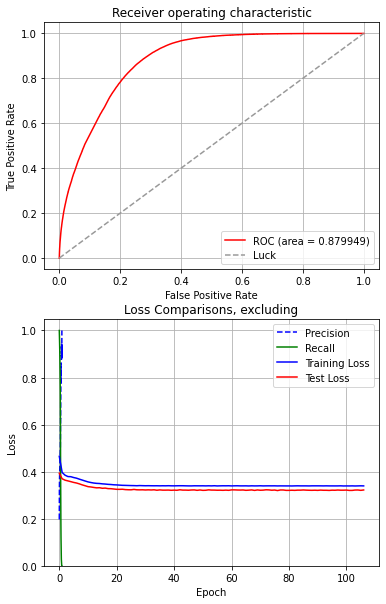

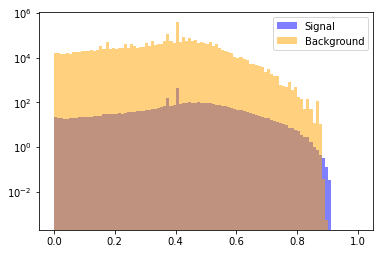

0         3.876874e-09
1         3.876874e-09
2         3.876874e-09
3         3.876874e-09
4         3.876874e-09
              ...     
214277    7.744040e-09
214278    7.744040e-09
214279    7.744040e-09
214280    7.744040e-09
214281    7.744040e-09
Name: weight, Length: 214282, dtype: float64
Script starting....
 [10, 10, 1]
CPU
Epoch 1/120
1763/1763 [==============================] - 2s 1ms/step - loss: 0.4683 - precision_2: 0.3623 - val_loss: 0.3880 - val_precision_2: 0.7174
Epoch 2/120
1763/1763 [==============================] - 2s 925us/step - loss: 0.3920 - precision_2: 0.6220 - val_loss: 0.3604 - val_precision_2: 0.6976
Epoch 3/120
1763/1763 [==============================] - 2s 917us/step - loss: 0.3781 - precision_2: 0.6216 - val_loss: 0.3540 - val_precision_2: 0.6963
Epoch 4/120
1763/1763 [==============================] - 2s 928us/step - loss: 0.3743 - precision_2: 0.6305 - val_loss: 0.3512 - val_precision_2: 0.7198
Epoch 5/120
1763/1763 [==============================] 

1763/1763 [==============================] - 2s 922us/step - loss: 0.3373 - precision_2: 0.6565 - val_loss: 0.3138 - val_precision_2: 0.6713
Epoch 53/120
1763/1763 [==============================] - 2s 916us/step - loss: 0.3371 - precision_2: 0.6574 - val_loss: 0.3157 - val_precision_2: 0.7181
Epoch 54/120
1763/1763 [==============================] - 2s 922us/step - loss: 0.3376 - precision_2: 0.6543 - val_loss: 0.3156 - val_precision_2: 0.6983
Epoch 55/120
1763/1763 [==============================] - 2s 920us/step - loss: 0.3372 - precision_2: 0.6573 - val_loss: 0.3133 - val_precision_2: 0.6772
Epoch 56/120
1763/1763 [==============================] - 2s 926us/step - loss: 0.3373 - precision_2: 0.6566 - val_loss: 0.3144 - val_precision_2: 0.6832
Epoch 57/120
1763/1763 [==============================] - 2s 927us/step - loss: 0.3368 - precision_2: 0.6566 - val_loss: 0.3138 - val_precision_2: 0.7043
Epoch 58/120
1763/1763 [==============================] - 2s 919us/step - loss: 0.3365 - 

1763/1763 [==============================] - 2s 910us/step - loss: 0.3334 - precision_2: 0.6623 - val_loss: 0.3122 - val_precision_2: 0.7011
Epoch 106/120
1763/1763 [==============================] - 2s 920us/step - loss: 0.3332 - precision_2: 0.6639 - val_loss: 0.3112 - val_precision_2: 0.7070
Epoch 107/120
1763/1763 [==============================] - 2s 920us/step - loss: 0.3336 - precision_2: 0.6642 - val_loss: 0.3108 - val_precision_2: 0.7027
Epoch 108/120
1763/1763 [==============================] - 2s 934us/step - loss: 0.3334 - precision_2: 0.6641 - val_loss: 0.3117 - val_precision_2: 0.7167
Epoch 109/120
1763/1763 [==============================] - 2s 909us/step - loss: 0.3334 - precision_2: 0.6643 - val_loss: 0.3113 - val_precision_2: 0.6917
Epoch 110/120
1763/1763 [==============================] - 2s 922us/step - loss: 0.3329 - precision_2: 0.6644 - val_loss: 0.3118 - val_precision_2: 0.7071
Epoch 111/120
1763/1763 [==============================] - 2s 924us/step - loss: 0.3

No handles with labels found to put in legend.


Signal:  214282 
 EWK:  672533 
 QCD:  252400 
 All Background:  924933 
 S/N:  0.23167299685490733

 Score =  0.000
 Signif =  0.00
 nsig = 0
 nbkg = 843096
 Scored S/N = 0



Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


FileName                                                                          ConfusionMatrix [TP FP] [FN TN]   Run Time               AUC     Avg.P   Score   Max Signif nsig    nbkg    Scored S/N  
 /home/examples/2022.04.27_20.43.42.numLayers3.numBr anches10.batchSize512.CPU.h5  ([177734, 5403], [29061, 13367]) 0 days 00:05:50.612196  0.8871  0.6235   0.000   0.00      214282  924933  1.57793e-09
Saving model.....
old auc: 
 0.8870523255750892 
 new auc 0.8871
Model Saved
Significance for

 Score =  0.000
 Signif =  0.00
 nsig = 0
 nbkg = 843096
 Scored S/N = 0



Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


FileName                                                                          ConfusionMatrix [TP FP] [FN TN]   Run Time               AUC     Avg.P   Score   Max Signif nsig    nbkg    Scored S/N  
 /home/examples/2022.04.27_20.43.42.numLayers3.numBr anches10.batchSize512.CPU.h5  ([177734, 5403], [29061, 13367]) 0 days 00:06:12.413102  0.8871  0.6235   0.000   0.00      214282  924933  1.57793e-09
Saving model.....
old auc: 
 0.8870523255750892 
 new auc 0.8871
Model Saved


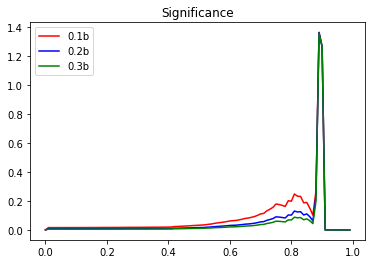

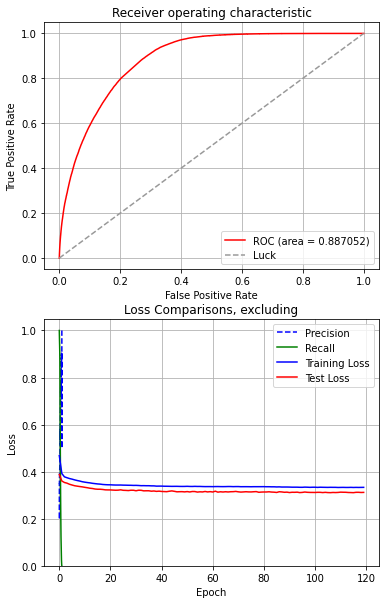

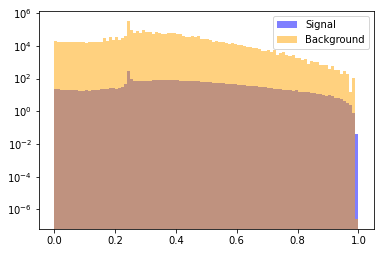

0         3.876874e-09
1         3.876874e-09
2         3.876874e-09
3         3.876874e-09
4         3.876874e-09
              ...     
214277    7.744040e-09
214278    7.744040e-09
214279    7.744040e-09
214280    7.744040e-09
214281    7.744040e-09
Name: weight, Length: 214282, dtype: float64
Script starting....
 [10, 10, 1]
CPU
Epoch 1/120
1763/1763 [==============================] - 2s 980us/step - loss: 0.4822 - precision_3: 0.3218 - val_loss: 0.4171 - val_precision_3: 0.8333
Epoch 2/120
1763/1763 [==============================] - 2s 913us/step - loss: 0.4178 - precision_3: 0.6042 - val_loss: 0.3914 - val_precision_3: 0.7225
Epoch 3/120
1763/1763 [==============================] - 2s 913us/step - loss: 0.4066 - precision_3: 0.6119 - val_loss: 0.3867 - val_precision_3: 0.7153
Epoch 4/120
1763/1763 [==============================] - 2s 914us/step - loss: 0.4022 - precision_3: 0.6130 - val_loss: 0.3842 - val_precision_3: 0.7246
Epoch 5/120
1763/1763 [==============================

1763/1763 [==============================] - 2s 926us/step - loss: 0.3523 - precision_3: 0.6507 - val_loss: 0.3320 - val_precision_3: 0.7151
Epoch 53/120
1763/1763 [==============================] - 2s 913us/step - loss: 0.3527 - precision_3: 0.6482 - val_loss: 0.3340 - val_precision_3: 0.7108
Epoch 54/120
1763/1763 [==============================] - 2s 913us/step - loss: 0.3520 - precision_3: 0.6512 - val_loss: 0.3317 - val_precision_3: 0.6973
Epoch 55/120
1763/1763 [==============================] - 2s 914us/step - loss: 0.3527 - precision_3: 0.6487 - val_loss: 0.3320 - val_precision_3: 0.7118
Epoch 56/120
1763/1763 [==============================] - 2s 917us/step - loss: 0.3523 - precision_3: 0.6501 - val_loss: 0.3319 - val_precision_3: 0.7094
Epoch 57/120
1763/1763 [==============================] - 2s 922us/step - loss: 0.3523 - precision_3: 0.6498 - val_loss: 0.3313 - val_precision_3: 0.6983
Epoch 58/120
1763/1763 [==============================] - 2s 928us/step - loss: 0.3521 - 

1763/1763 [==============================] - 2s 901us/step - loss: 0.3497 - precision_3: 0.6505 - val_loss: 0.3325 - val_precision_3: 0.7181
Epoch 106/120
1763/1763 [==============================] - 2s 909us/step - loss: 0.3496 - precision_3: 0.6491 - val_loss: 0.3316 - val_precision_3: 0.6879
Epoch 107/120
1763/1763 [==============================] - 2s 915us/step - loss: 0.3495 - precision_3: 0.6509 - val_loss: 0.3300 - val_precision_3: 0.6807
Epoch 108/120
1763/1763 [==============================] - 2s 908us/step - loss: 0.3495 - precision_3: 0.6520 - val_loss: 0.3304 - val_precision_3: 0.7044
Epoch 109/120
1763/1763 [==============================] - 2s 910us/step - loss: 0.3495 - precision_3: 0.6503 - val_loss: 0.3305 - val_precision_3: 0.6665
Epoch 110/120
1763/1763 [==============================] - 2s 904us/step - loss: 0.3493 - precision_3: 0.6517 - val_loss: 0.3312 - val_precision_3: 0.6869
Epoch 111/120
1763/1763 [==============================] - 2s 914us/step - loss: 0.3

No handles with labels found to put in legend.


Signal:  214282 
 EWK:  672533 
 QCD:  252400 
 All Background:  924933 
 S/N:  0.23167299685490733

 Score =  0.000
 Signif =  0.00
 nsig = 0
 nbkg = 885470
 Scored S/N = 0



Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


FileName                                                                          ConfusionMatrix [TP FP] [FN TN]   Run Time               AUC     Avg.P   Score   Max Signif nsig    nbkg    Scored S/N  
 /home/examples/2022.04.27_20.55.03.numLayers3.numBr anches10.batchSize512.CPU.h5  ([178050, 5087], [30194, 12234]) 0 days 00:05:54.438777  0.8682  0.5950   0.000   0.00      214282  924933  1.50231e-09
Saving model.....
old auc: 
 0.8681971518679481 
 new auc 0.8682
Model Saved
Significance for

 Score =  0.000
 Signif =  0.00
 nsig = 0
 nbkg = 885470
 Scored S/N = 0



Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


FileName                                                                          ConfusionMatrix [TP FP] [FN TN]   Run Time               AUC     Avg.P   Score   Max Signif nsig    nbkg    Scored S/N  
 /home/examples/2022.04.27_20.55.03.numLayers3.numBr anches10.batchSize512.CPU.h5  ([178050, 5087], [30194, 12234]) 0 days 00:06:15.940137  0.8682  0.5950   0.000   0.00      214282  924933  1.50231e-09
Saving model.....
old auc: 
 0.8681971518679481 
 new auc 0.8682
Model Saved


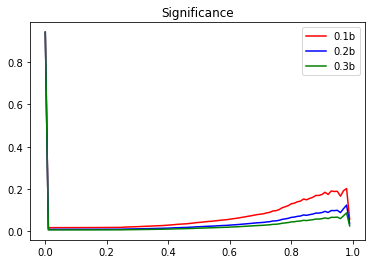

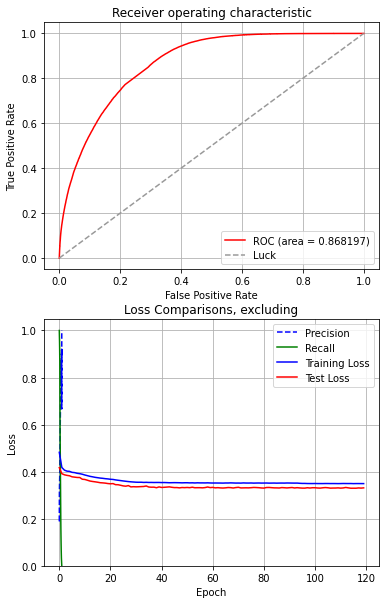

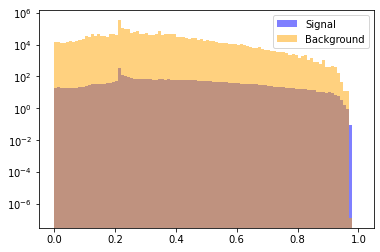

0         3.876874e-09
1         3.876874e-09
2         3.876874e-09
3         3.876874e-09
4         3.876874e-09
              ...     
214277    7.744040e-09
214278    7.744040e-09
214279    7.744040e-09
214280    7.744040e-09
214281    7.744040e-09
Name: weight, Length: 214282, dtype: float64
Script starting....
 [10, 10, 1]
CPU
Epoch 1/120
1763/1763 [==============================] - 2s 984us/step - loss: 0.4713 - precision_4: 0.1578 - val_loss: 0.4118 - val_precision_4: 0.0000e+00
Epoch 2/120
1763/1763 [==============================] - 2s 932us/step - loss: 0.3892 - precision_4: 0.6047 - val_loss: 0.3620 - val_precision_4: 0.7543
Epoch 3/120
1763/1763 [==============================] - 2s 912us/step - loss: 0.3776 - precision_4: 0.6087 - val_loss: 0.3579 - val_precision_4: 0.7348
Epoch 4/120
1763/1763 [==============================] - 2s 905us/step - loss: 0.3732 - precision_4: 0.6142 - val_loss: 0.3553 - val_precision_4: 0.7270
Epoch 5/120
1763/1763 [==========================

1763/1763 [==============================] - 2s 896us/step - loss: 0.3610 - precision_4: 0.6450 - val_loss: 0.3445 - val_precision_4: 0.7243
Epoch 53/120
1763/1763 [==============================] - 2s 904us/step - loss: 0.3610 - precision_4: 0.6432 - val_loss: 0.3443 - val_precision_4: 0.7222
Epoch 54/120
1763/1763 [==============================] - 2s 905us/step - loss: 0.3609 - precision_4: 0.6446 - val_loss: 0.3437 - val_precision_4: 0.7224
Epoch 55/120
1763/1763 [==============================] - 2s 905us/step - loss: 0.3607 - precision_4: 0.6461 - val_loss: 0.3435 - val_precision_4: 0.7156
Epoch 56/120
1763/1763 [==============================] - 2s 911us/step - loss: 0.3606 - precision_4: 0.6432 - val_loss: 0.3433 - val_precision_4: 0.7215
Epoch 57/120
1763/1763 [==============================] - 2s 895us/step - loss: 0.3608 - precision_4: 0.6443 - val_loss: 0.3437 - val_precision_4: 0.7206
Epoch 58/120
1763/1763 [==============================] - 2s 919us/step - loss: 0.3610 - 

1763/1763 [==============================] - 2s 914us/step - loss: 0.3596 - precision_4: 0.6451 - val_loss: 0.3433 - val_precision_4: 0.7344
Epoch 106/120
1763/1763 [==============================] - 2s 910us/step - loss: 0.3597 - precision_4: 0.6450 - val_loss: 0.3425 - val_precision_4: 0.7177
Epoch 107/120
1763/1763 [==============================] - 2s 914us/step - loss: 0.3595 - precision_4: 0.6451 - val_loss: 0.3417 - val_precision_4: 0.7129
Epoch 108/120
1763/1763 [==============================] - 2s 902us/step - loss: 0.3594 - precision_4: 0.6467 - val_loss: 0.3426 - val_precision_4: 0.7061
Epoch 109/120
1763/1763 [==============================] - 2s 916us/step - loss: 0.3594 - precision_4: 0.6451 - val_loss: 0.3416 - val_precision_4: 0.7121
Epoch 110/120
1763/1763 [==============================] - 2s 907us/step - loss: 0.3597 - precision_4: 0.6450 - val_loss: 0.3431 - val_precision_4: 0.7290
Epoch 111/120
1763/1763 [==============================] - 2s 912us/step - loss: 0.3

No handles with labels found to put in legend.


Signal:  214282 
 EWK:  672533 
 QCD:  252400 
 All Background:  924933 
 S/N:  0.23167299685490733

 Score =  0.000
 Signif =  0.00
 nsig = 0
 nbkg = 908894
 Scored S/N = 0



Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


FileName                                                                          ConfusionMatrix [TP FP] [FN TN]  Run Time               AUC     Avg.P   Score   Max Signif nsig    nbkg    Scored S/N  
 /home/examples/2022.04.27_21.06.39.numLayers3.numBr anches10.batchSize512.CPU.h5  ([179130, 4007], [32507, 9921]) 0 days 00:05:48.744518  0.8618  0.5755   0.000   0.00      214282  924933  1.46354e-09
Saving model.....
old auc: 
 0.861790295549701 
 new auc 0.8618
Model Saved
Significance for

 Score =  0.000
 Signif =  0.00
 nsig = 0
 nbkg = 908894
 Scored S/N = 0



Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


FileName                                                                          ConfusionMatrix [TP FP] [FN TN]  Run Time               AUC     Avg.P   Score   Max Signif nsig    nbkg    Scored S/N  
 /home/examples/2022.04.27_21.06.39.numLayers3.numBr anches10.batchSize512.CPU.h5  ([179130, 4007], [32507, 9921]) 0 days 00:06:10.432235  0.8618  0.5755   0.000   0.00      214282  924933  1.46354e-09
Saving model.....
old auc: 
 0.861790295549701 
 new auc 0.8618
Model Saved


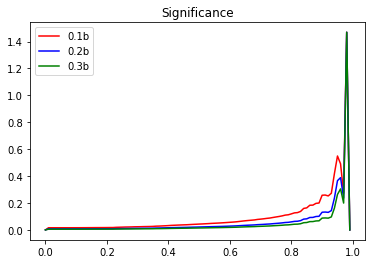

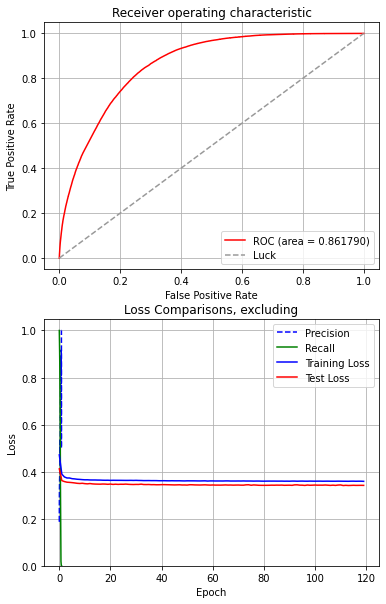

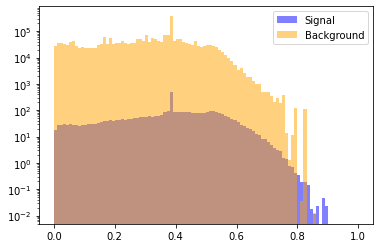

0         3.876874e-09
1         3.876874e-09
2         3.876874e-09
3         3.876874e-09
4         3.876874e-09
              ...     
214277    7.744040e-09
214278    7.744040e-09
214279    7.744040e-09
214280    7.744040e-09
214281    7.744040e-09
Name: weight, Length: 214282, dtype: float64
Script starting....
 [10, 10, 1]
CPU
Epoch 1/120
1763/1763 [==============================] - 2s 996us/step - loss: 0.4840 - precision_5: 0.1683 - val_loss: 0.4336 - val_precision_5: 1.0000
Epoch 2/120
1763/1763 [==============================] - 2s 907us/step - loss: 0.4252 - precision_5: 0.5149 - val_loss: 0.3855 - val_precision_5: 0.5429
Epoch 3/120
1763/1763 [==============================] - 2s 914us/step - loss: 0.3866 - precision_5: 0.6193 - val_loss: 0.3554 - val_precision_5: 0.6815
Epoch 4/120
1763/1763 [==============================] - 2s 910us/step - loss: 0.3683 - precision_5: 0.6303 - val_loss: 0.3469 - val_precision_5: 0.6742
Epoch 5/120
1763/1763 [==============================

1763/1763 [==============================] - 2s 912us/step - loss: 0.3298 - precision_5: 0.6706 - val_loss: 0.3106 - val_precision_5: 0.6812
Epoch 53/120
1763/1763 [==============================] - 2s 903us/step - loss: 0.3294 - precision_5: 0.6709 - val_loss: 0.3118 - val_precision_5: 0.6794
Epoch 54/120
1763/1763 [==============================] - 2s 915us/step - loss: 0.3293 - precision_5: 0.6724 - val_loss: 0.3126 - val_precision_5: 0.7059
Epoch 55/120
1763/1763 [==============================] - 2s 908us/step - loss: 0.3292 - precision_5: 0.6706 - val_loss: 0.3108 - val_precision_5: 0.6862
Epoch 56/120
1763/1763 [==============================] - 2s 904us/step - loss: 0.3286 - precision_5: 0.6707 - val_loss: 0.3110 - val_precision_5: 0.6884
Epoch 57/120
1763/1763 [==============================] - 2s 932us/step - loss: 0.3293 - precision_5: 0.6724 - val_loss: 0.3108 - val_precision_5: 0.6921
Epoch 58/120
1763/1763 [==============================] - 2s 921us/step - loss: 0.3289 - 

1763/1763 [==============================] - 2s 919us/step - loss: 0.3265 - precision_5: 0.6795 - val_loss: 0.3108 - val_precision_5: 0.7141
Epoch 106/120
1763/1763 [==============================] - 2s 914us/step - loss: 0.3263 - precision_5: 0.6780 - val_loss: 0.3109 - val_precision_5: 0.7271
Epoch 107/120
1763/1763 [==============================] - 2s 909us/step - loss: 0.3265 - precision_5: 0.6811 - val_loss: 0.3082 - val_precision_5: 0.7018
Epoch 108/120
1763/1763 [==============================] - 2s 923us/step - loss: 0.3267 - precision_5: 0.6773 - val_loss: 0.3090 - val_precision_5: 0.6959
Epoch 109/120
1763/1763 [==============================] - 2s 924us/step - loss: 0.3268 - precision_5: 0.6800 - val_loss: 0.3099 - val_precision_5: 0.7078
Epoch 110/120
1763/1763 [==============================] - 2s 917us/step - loss: 0.3261 - precision_5: 0.6787 - val_loss: 0.3089 - val_precision_5: 0.7081
Epoch 111/120
1763/1763 [==============================] - 2s 902us/step - loss: 0.3

No handles with labels found to put in legend.


Signal:  214282 
 EWK:  672533 
 QCD:  252400 
 All Background:  924933 
 S/N:  0.23167299685490733

 Score =  0.000
 Signif =  0.00
 nsig = 0
 nbkg = 786777
 Scored S/N = 0



Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


FileName                                                                          ConfusionMatrix [TP FP] [FN TN]   Run Time               AUC     Avg.P   Score   Max Signif nsig    nbkg    Scored S/N  
 /home/examples/2022.04.27_21.18.09.numLayers3.numBr anches10.batchSize512.CPU.h5  ([176737, 6400], [27537, 14891]) 0 days 00:05:52.720321  0.8894  0.6293   0.000   0.00      214282  924933  1.69063e-09
Saving model.....
old auc: 
 0.8894148120872246 
 new auc 0.8894
Model Saved
Significance for

 Score =  0.000
 Signif =  0.00
 nsig = 0
 nbkg = 786777
 Scored S/N = 0



Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


FileName                                                                          ConfusionMatrix [TP FP] [FN TN]   Run Time               AUC     Avg.P   Score   Max Signif nsig    nbkg    Scored S/N  
 /home/examples/2022.04.27_21.18.09.numLayers3.numBr anches10.batchSize512.CPU.h5  ([176737, 6400], [27537, 14891]) 0 days 00:06:14.625829  0.8894  0.6293   0.000   0.00      214282  924933  1.69063e-09
Saving model.....
old auc: 
 0.8894148120872246 
 new auc 0.8894
Model Saved


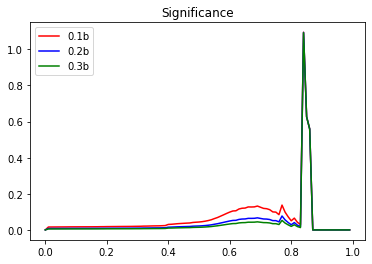

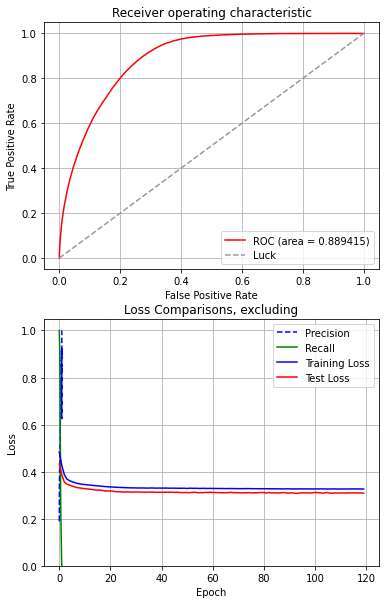

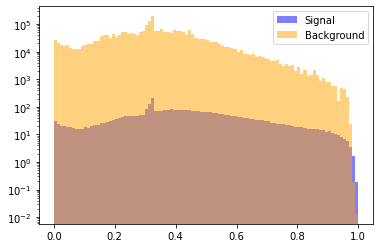

0         3.876874e-09
1         3.876874e-09
2         3.876874e-09
3         3.876874e-09
4         3.876874e-09
              ...     
214277    7.744040e-09
214278    7.744040e-09
214279    7.744040e-09
214280    7.744040e-09
214281    7.744040e-09
Name: weight, Length: 214282, dtype: float64
Script starting....
 [10, 10, 1]
CPU
Epoch 1/120
1763/1763 [==============================] - 2s 980us/step - loss: 0.4419 - precision_6: 0.4873 - val_loss: 0.3826 - val_precision_6: 0.0000e+00
Epoch 2/120
1763/1763 [==============================] - 2s 927us/step - loss: 0.3928 - precision_6: 0.6186 - val_loss: 0.3690 - val_precision_6: 0.7012
Epoch 3/120
1763/1763 [==============================] - 2s 910us/step - loss: 0.3833 - precision_6: 0.6189 - val_loss: 0.3637 - val_precision_6: 0.6936
Epoch 4/120
1763/1763 [==============================] - 2s 902us/step - loss: 0.3799 - precision_6: 0.6213 - val_loss: 0.3608 - val_precision_6: 0.6920
Epoch 5/120
1763/1763 [==========================

1763/1763 [==============================] - 2s 897us/step - loss: 0.3313 - precision_6: 0.6651 - val_loss: 0.3130 - val_precision_6: 0.7055
Epoch 53/120
1763/1763 [==============================] - 2s 906us/step - loss: 0.3316 - precision_6: 0.6613 - val_loss: 0.3129 - val_precision_6: 0.7108
Epoch 54/120
1763/1763 [==============================] - 2s 917us/step - loss: 0.3314 - precision_6: 0.6638 - val_loss: 0.3133 - val_precision_6: 0.7009
Epoch 55/120
1763/1763 [==============================] - 2s 918us/step - loss: 0.3312 - precision_6: 0.6610 - val_loss: 0.3126 - val_precision_6: 0.7196
Epoch 56/120
1763/1763 [==============================] - 2s 909us/step - loss: 0.3313 - precision_6: 0.6651 - val_loss: 0.3133 - val_precision_6: 0.7094
Epoch 57/120
1763/1763 [==============================] - 2s 926us/step - loss: 0.3310 - precision_6: 0.6633 - val_loss: 0.3132 - val_precision_6: 0.7171
Epoch 58/120
1763/1763 [==============================] - 2s 916us/step - loss: 0.3313 - 

1763/1763 [==============================] - 2s 912us/step - loss: 0.3305 - precision_6: 0.6633 - val_loss: 0.3125 - val_precision_6: 0.6972
Epoch 106/120
1763/1763 [==============================] - 2s 909us/step - loss: 0.3302 - precision_6: 0.6626 - val_loss: 0.3122 - val_precision_6: 0.6969
Epoch 107/120
1763/1763 [==============================] - 2s 915us/step - loss: 0.3305 - precision_6: 0.6640 - val_loss: 0.3123 - val_precision_6: 0.6843
Epoch 108/120
1763/1763 [==============================] - 2s 888us/step - loss: 0.3303 - precision_6: 0.6620 - val_loss: 0.3110 - val_precision_6: 0.6971
Epoch 109/120
1763/1763 [==============================] - 2s 898us/step - loss: 0.3299 - precision_6: 0.6636 - val_loss: 0.3108 - val_precision_6: 0.6859
Epoch 110/120
1763/1763 [==============================] - 2s 905us/step - loss: 0.3304 - precision_6: 0.6625 - val_loss: 0.3116 - val_precision_6: 0.7099
Epoch 111/120
1763/1763 [==============================] - 2s 884us/step - loss: 0.3

No handles with labels found to put in legend.


Signal:  214282 
 EWK:  672533 
 QCD:  252400 
 All Background:  924933 
 S/N:  0.23167299685490733

 Score =  0.000
 Signif =  0.00
 nsig = 0
 nbkg = 789896
 Scored S/N = 0



Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


FileName                                                                          ConfusionMatrix [TP FP] [FN TN]   Run Time               AUC     Avg.P   Score   Max Signif nsig    nbkg    Scored S/N  
 /home/examples/2022.04.27_21.29.40.numLayers3.numBr anches10.batchSize512.CPU.h5  ([177262, 5875], [28482, 13946]) 0 days 00:05:51.669405  0.8890  0.6233   0.000   0.00      214282  924933  1.68415e-09
Saving model.....
old auc: 
 0.8890369811509709 
 new auc 0.8890
Model Saved
Significance for

 Score =  0.000
 Signif =  0.00
 nsig = 0
 nbkg = 789896
 Scored S/N = 0



Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


FileName                                                                          ConfusionMatrix [TP FP] [FN TN]   Run Time               AUC     Avg.P   Score   Max Signif nsig    nbkg    Scored S/N  
 /home/examples/2022.04.27_21.29.40.numLayers3.numBr anches10.batchSize512.CPU.h5  ([177262, 5875], [28482, 13946]) 0 days 00:06:13.124109  0.8890  0.6233   0.000   0.00      214282  924933  1.68415e-09
Saving model.....
old auc: 
 0.8890369811509709 
 new auc 0.8890
Model Saved


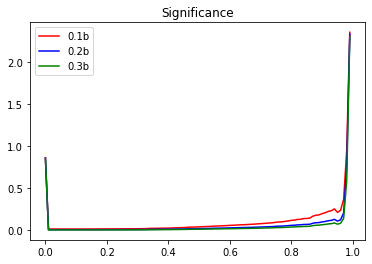

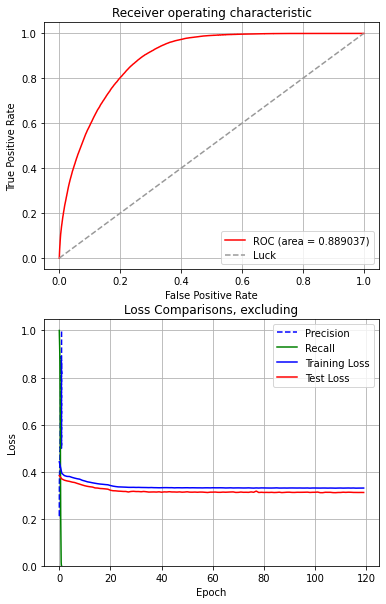

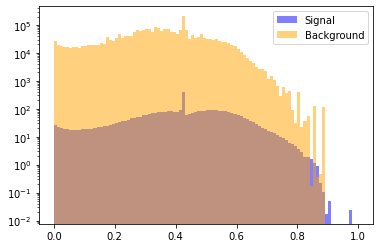

0         3.876874e-09
1         3.876874e-09
2         3.876874e-09
3         3.876874e-09
4         3.876874e-09
              ...     
214277    7.744040e-09
214278    7.744040e-09
214279    7.744040e-09
214280    7.744040e-09
214281    7.744040e-09
Name: weight, Length: 214282, dtype: float64
Script starting....
 [10, 10, 1]
CPU
Epoch 1/120
1763/1763 [==============================] - 2s 976us/step - loss: 0.4488 - precision_7: 0.4225 - val_loss: 0.3777 - val_precision_7: 0.7463
Epoch 2/120
1763/1763 [==============================] - 2s 928us/step - loss: 0.3904 - precision_7: 0.5825 - val_loss: 0.3667 - val_precision_7: 0.7013
Epoch 3/120
1763/1763 [==============================] - 2s 912us/step - loss: 0.3791 - precision_7: 0.6247 - val_loss: 0.3559 - val_precision_7: 0.6835
Epoch 4/120
1763/1763 [==============================] - 2s 924us/step - loss: 0.3729 - precision_7: 0.6388 - val_loss: 0.3505 - val_precision_7: 0.6756
Epoch 5/120
1763/1763 [==============================

1763/1763 [==============================] - 2s 1ms/step - loss: 0.3308 - precision_7: 0.6672 - val_loss: 0.3105 - val_precision_7: 0.6892
Epoch 53/120
1763/1763 [==============================] - 2s 1ms/step - loss: 0.3306 - precision_7: 0.6674 - val_loss: 0.3108 - val_precision_7: 0.6902
Epoch 54/120
1763/1763 [==============================] - 2s 1ms/step - loss: 0.3306 - precision_7: 0.6684 - val_loss: 0.3125 - val_precision_7: 0.7232
Epoch 55/120
1763/1763 [==============================] - 2s 1ms/step - loss: 0.3303 - precision_7: 0.6680 - val_loss: 0.3122 - val_precision_7: 0.6887
Epoch 56/120
1763/1763 [==============================] - 2s 1ms/step - loss: 0.3300 - precision_7: 0.6675 - val_loss: 0.3097 - val_precision_7: 0.6937
Epoch 57/120
1763/1763 [==============================] - 2s 1ms/step - loss: 0.3303 - precision_7: 0.6672 - val_loss: 0.3100 - val_precision_7: 0.6943
Epoch 58/120
1763/1763 [==============================] - 2s 1ms/step - loss: 0.3305 - precision_7: 0

Epoch 106/120
1763/1763 [==============================] - 2s 1ms/step - loss: 0.3300 - precision_7: 0.6692 - val_loss: 0.3123 - val_precision_7: 0.7193
Epoch 107/120
1763/1763 [==============================] - 2s 1ms/step - loss: 0.3302 - precision_7: 0.6712 - val_loss: 0.3103 - val_precision_7: 0.7103
Epoch 108/120
1763/1763 [==============================] - 2s 1ms/step - loss: 0.3298 - precision_7: 0.6710 - val_loss: 0.3100 - val_precision_7: 0.6950
Epoch 109/120
1763/1763 [==============================] - 2s 1ms/step - loss: 0.3295 - precision_7: 0.6707 - val_loss: 0.3109 - val_precision_7: 0.6924
Epoch 110/120
1763/1763 [==============================] - 2s 1ms/step - loss: 0.3297 - precision_7: 0.6721 - val_loss: 0.3107 - val_precision_7: 0.7133
Epoch 111/120
1763/1763 [==============================] - 2s 1ms/step - loss: 0.3297 - precision_7: 0.6719 - val_loss: 0.3098 - val_precision_7: 0.7146
Epoch 112/120
1763/1763 [==============================] - 2s 1ms/step - loss: 0.3

No handles with labels found to put in legend.


Signal:  214282 
 EWK:  672533 
 QCD:  252400 
 All Background:  924933 
 S/N:  0.23167299685490733

 Score =  0.000
 Signif =  0.00
 nsig = 0
 nbkg = 877105
 Scored S/N = 0



Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


FileName                                                                          ConfusionMatrix [TP FP] [FN TN]   Run Time               AUC     Avg.P   Score   Max Signif nsig    nbkg    Scored S/N  
 /home/examples/2022.04.27_21.41.17.numLayers3.numBr anches10.batchSize512.CPU.h5  ([176321, 6816], [27177, 15251]) 0 days 00:07:01.608265  0.8890  0.6244   0.000   0.00      214282  924933  1.51677e-09
Saving model.....
old auc: 
 0.8890267069429691 
 new auc 0.8890
Model Saved
Significance for

 Score =  0.000
 Signif =  0.00
 nsig = 0
 nbkg = 877105
 Scored S/N = 0



Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


FileName                                                                          ConfusionMatrix [TP FP] [FN TN]   Run Time               AUC     Avg.P   Score   Max Signif nsig    nbkg    Scored S/N  
 /home/examples/2022.04.27_21.41.17.numLayers3.numBr anches10.batchSize512.CPU.h5  ([176321, 6816], [27177, 15251]) 0 days 00:07:34.348867  0.8890  0.6244   0.000   0.00      214282  924933  1.51677e-09
Saving model.....
old auc: 
 0.8890267069429691 
 new auc 0.8890
Model Saved


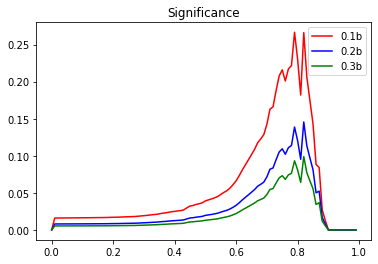

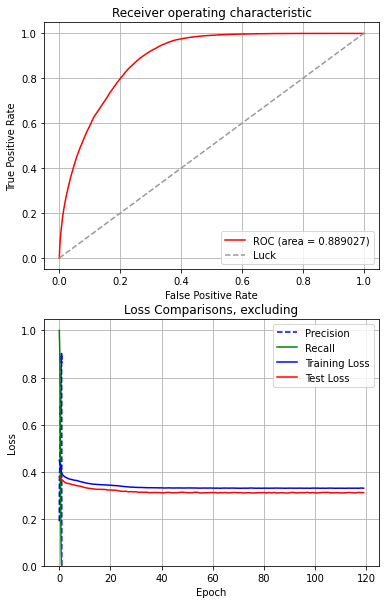

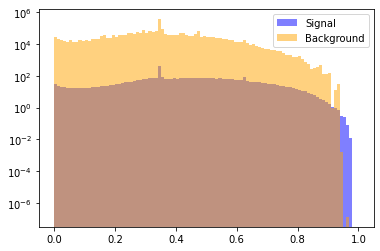

0         3.876874e-09
1         3.876874e-09
2         3.876874e-09
3         3.876874e-09
4         3.876874e-09
              ...     
214277    7.744040e-09
214278    7.744040e-09
214279    7.744040e-09
214280    7.744040e-09
214281    7.744040e-09
Name: weight, Length: 214282, dtype: float64
Script starting....
 [10, 10, 1]
CPU
Epoch 1/120
1763/1763 [==============================] - 2s 999us/step - loss: 0.4648 - precision_8: 0.2244 - val_loss: 0.3843 - val_precision_8: 0.6120
Epoch 2/120
1763/1763 [==============================] - 2s 934us/step - loss: 0.3920 - precision_8: 0.6280 - val_loss: 0.3621 - val_precision_8: 0.7014
Epoch 3/120
1763/1763 [==============================] - 2s 910us/step - loss: 0.3790 - precision_8: 0.6358 - val_loss: 0.3567 - val_precision_8: 0.6850
Epoch 4/120
1763/1763 [==============================] - 2s 923us/step - loss: 0.3769 - precision_8: 0.6420 - val_loss: 0.3545 - val_precision_8: 0.7037
Epoch 5/120
1763/1763 [==============================

1763/1763 [==============================] - 2s 922us/step - loss: 0.3325 - precision_8: 0.6733 - val_loss: 0.3123 - val_precision_8: 0.7376
Epoch 53/120
1763/1763 [==============================] - 2s 907us/step - loss: 0.3326 - precision_8: 0.6758 - val_loss: 0.3114 - val_precision_8: 0.7187
Epoch 54/120
1763/1763 [==============================] - 2s 908us/step - loss: 0.3320 - precision_8: 0.6740 - val_loss: 0.3105 - val_precision_8: 0.7075
Epoch 55/120
1763/1763 [==============================] - 2s 918us/step - loss: 0.3325 - precision_8: 0.6756 - val_loss: 0.3106 - val_precision_8: 0.7047
Epoch 56/120
1763/1763 [==============================] - 2s 944us/step - loss: 0.3329 - precision_8: 0.6764 - val_loss: 0.3111 - val_precision_8: 0.6912
Epoch 57/120
1763/1763 [==============================] - 2s 914us/step - loss: 0.3325 - precision_8: 0.6738 - val_loss: 0.3106 - val_precision_8: 0.7114
Epoch 58/120
1763/1763 [==============================] - 2s 922us/step - loss: 0.3324 - 

No handles with labels found to put in legend.


Signal:  214282 
 EWK:  672533 
 QCD:  252400 
 All Background:  924933 
 S/N:  0.23167299685490733

 Score =  0.000
 Signif =  0.00
 nsig = 0
 nbkg = 857142
 Scored S/N = 0



Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


FileName                                                                          ConfusionMatrix [TP FP] [FN TN]   Run Time               AUC     Avg.P   Score   Max Signif nsig    nbkg    Scored S/N  
 /home/examples/2022.04.27_21.54.54.numLayers3.numBr anches10.batchSize512.CPU.h5  ([177405, 5732], [28515, 13913]) 0 days 00:04:46.519806  0.8882  0.6234   0.000   0.00      214282  924933  1.55207e-09
Saving model.....
old auc: 
 0.8882118226241189 
 new auc 0.8882
Model Saved
Significance for

 Score =  0.000
 Signif =  0.00
 nsig = 0
 nbkg = 857142
 Scored S/N = 0



Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


FileName                                                                          ConfusionMatrix [TP FP] [FN TN]   Run Time               AUC     Avg.P   Score   Max Signif nsig    nbkg    Scored S/N  
 /home/examples/2022.04.27_21.54.54.numLayers3.numBr anches10.batchSize512.CPU.h5  ([177405, 5732], [28515, 13913]) 0 days 00:05:08.699854  0.8882  0.6234   0.000   0.00      214282  924933  1.55207e-09
Saving model.....
old auc: 
 0.8882118226241189 
 new auc 0.8882
Model Saved


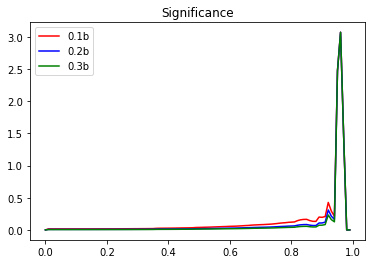

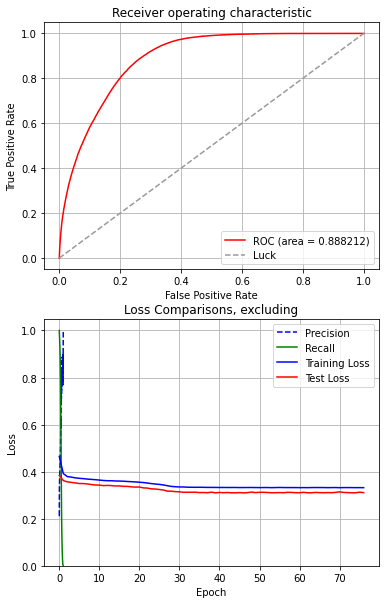

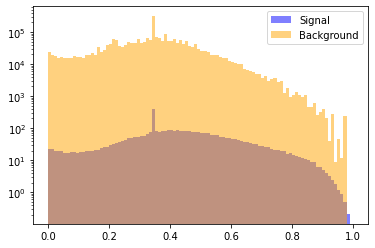

0         3.876874e-09
1         3.876874e-09
2         3.876874e-09
3         3.876874e-09
4         3.876874e-09
              ...     
214277    7.744040e-09
214278    7.744040e-09
214279    7.744040e-09
214280    7.744040e-09
214281    7.744040e-09
Name: weight, Length: 214282, dtype: float64
Script starting....
 [10, 10, 1]
CPU
Epoch 1/120
1763/1763 [==============================] - 2s 968us/step - loss: 0.4899 - precision_9: 0.1806 - val_loss: 0.4431 - val_precision_9: 0.0000e+00
Epoch 2/120
1763/1763 [==============================] - 2s 860us/step - loss: 0.4120 - precision_9: 0.5955 - val_loss: 0.3714 - val_precision_9: 0.6639
Epoch 3/120
1763/1763 [==============================] - 2s 861us/step - loss: 0.3852 - precision_9: 0.5906 - val_loss: 0.3652 - val_precision_9: 0.6596
Epoch 4/120
1763/1763 [==============================] - 2s 893us/step - loss: 0.3838 - precision_9: 0.6058 - val_loss: 0.3602 - val_precision_9: 0.6436
Epoch 5/120
1763/1763 [==========================

1763/1763 [==============================] - 2s 884us/step - loss: 0.3403 - precision_9: 0.6698 - val_loss: 0.3197 - val_precision_9: 0.6775
Epoch 53/120
1763/1763 [==============================] - 2s 929us/step - loss: 0.3401 - precision_9: 0.6691 - val_loss: 0.3229 - val_precision_9: 0.7417
Epoch 54/120
1763/1763 [==============================] - 2s 913us/step - loss: 0.3405 - precision_9: 0.6704 - val_loss: 0.3202 - val_precision_9: 0.6991
Epoch 55/120
1763/1763 [==============================] - 1s 814us/step - loss: 0.3399 - precision_9: 0.6711 - val_loss: 0.3213 - val_precision_9: 0.7145
Epoch 56/120
1763/1763 [==============================] - 1s 841us/step - loss: 0.3400 - precision_9: 0.6712 - val_loss: 0.3202 - val_precision_9: 0.7169
Epoch 57/120
1763/1763 [==============================] - 2s 879us/step - loss: 0.3400 - precision_9: 0.6713 - val_loss: 0.3199 - val_precision_9: 0.7129
Epoch 58/120
1763/1763 [==============================] - 2s 892us/step - loss: 0.3399 - 

1763/1763 [==============================] - 1s 821us/step - loss: 0.3396 - precision_9: 0.6739 - val_loss: 0.3193 - val_precision_9: 0.7057
Epoch 106/120
1763/1763 [==============================] - 1s 795us/step - loss: 0.3392 - precision_9: 0.6751 - val_loss: 0.3212 - val_precision_9: 0.7300
Epoch 107/120
1763/1763 [==============================] - 1s 849us/step - loss: 0.3396 - precision_9: 0.6742 - val_loss: 0.3191 - val_precision_9: 0.7068
Epoch 108/120
1763/1763 [==============================] - 2s 857us/step - loss: 0.3392 - precision_9: 0.6745 - val_loss: 0.3190 - val_precision_9: 0.7000
Epoch 109/120
1763/1763 [==============================] - 2s 863us/step - loss: 0.3393 - precision_9: 0.6735 - val_loss: 0.3208 - val_precision_9: 0.7227
Epoch 110/120
1763/1763 [==============================] - 2s 853us/step - loss: 0.3394 - precision_9: 0.6745 - val_loss: 0.3195 - val_precision_9: 0.7106
Epoch 111/120
1763/1763 [==============================] - 2s 890us/step - loss: 0.3

No handles with labels found to put in legend.


Signal:  214282 
 EWK:  672533 
 QCD:  252400 
 All Background:  924933 
 S/N:  0.23167299685490733

 Score =  0.000
 Signif =  0.00
 nsig = 0
 nbkg = 872379
 Scored S/N = 0



Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


FileName                                                                          ConfusionMatrix [TP FP] [FN TN]   Run Time               AUC     Avg.P   Score   Max Signif nsig    nbkg    Scored S/N  
 /home/examples/2022.04.27_22.05.33.numLayers3.numBr anches10.batchSize512.CPU.h5  ([176656, 6481], [28029, 14399]) 0 days 00:05:50.112526  0.8815  0.6133   0.000   0.00      214282  924933  1.52494e-09
Saving model.....
old auc: 
 0.8815342929447039 
 new auc 0.8815
Model Saved
Significance for

 Score =  0.000
 Signif =  0.00
 nsig = 0
 nbkg = 872379
 Scored S/N = 0



Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


FileName                                                                          ConfusionMatrix [TP FP] [FN TN]   Run Time               AUC     Avg.P   Score   Max Signif nsig    nbkg    Scored S/N  
 /home/examples/2022.04.27_22.05.33.numLayers3.numBr anches10.batchSize512.CPU.h5  ([176656, 6481], [28029, 14399]) 0 days 00:06:13.648265  0.8815  0.6133   0.000   0.00      214282  924933  1.52494e-09
Saving model.....
old auc: 
 0.8815342929447039 
 new auc 0.8815
Model Saved


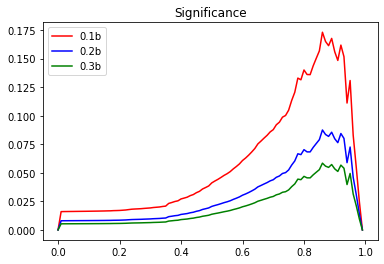

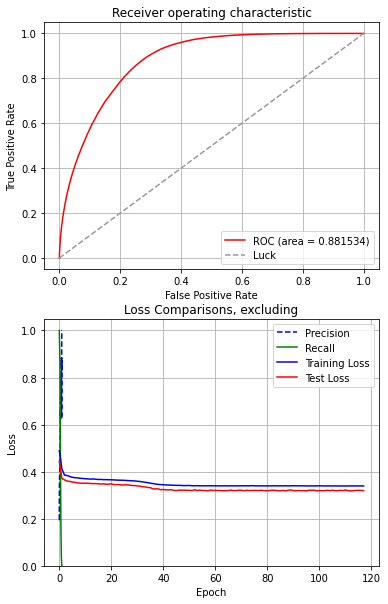

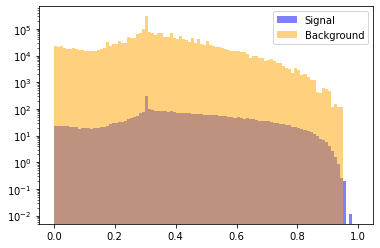

0         3.876874e-09
1         3.876874e-09
2         3.876874e-09
3         3.876874e-09
4         3.876874e-09
              ...     
214277    7.744040e-09
214278    7.744040e-09
214279    7.744040e-09
214280    7.744040e-09
214281    7.744040e-09
Name: weight, Length: 214282, dtype: float64
Script starting....
 [10, 10, 1]
CPU
Epoch 1/120
1763/1763 [==============================] - 3s 2ms/step - loss: 0.4601 - precision_10: 0.2080 - val_loss: 0.3987 - val_precision_10: 0.0000e+00
Epoch 2/120
1763/1763 [==============================] - 3s 2ms/step - loss: 0.4031 - precision_10: 0.5000 - val_loss: 0.3835 - val_precision_10: 0.0000e+00
Epoch 3/120
1763/1763 [==============================] - 2s 1ms/step - loss: 0.3960 - precision_10: 0.4000 - val_loss: 0.3779 - val_precision_10: 0.0000e+00
Epoch 4/120
1763/1763 [==============================] - 3s 2ms/step - loss: 0.3915 - precision_10: 0.0000e+00 - val_loss: 0.3725 - val_precision_10: 0.0000e+00
Epoch 5/120
1763/1763 [==========

1763/1763 [==============================] - 3s 2ms/step - loss: 0.3481 - precision_10: 0.0000e+00 - val_loss: 0.3317 - val_precision_10: 0.0000e+00
Epoch 50/120
1763/1763 [==============================] - 3s 1ms/step - loss: 0.3481 - precision_10: 0.0000e+00 - val_loss: 0.3314 - val_precision_10: 0.0000e+00
Epoch 51/120
1763/1763 [==============================] - 3s 1ms/step - loss: 0.3484 - precision_10: 0.0000e+00 - val_loss: 0.3315 - val_precision_10: 0.0000e+00
Epoch 52/120
1763/1763 [==============================] - 3s 2ms/step - loss: 0.3486 - precision_10: 0.0000e+00 - val_loss: 0.3314 - val_precision_10: 0.0000e+00
Epoch 53/120
1763/1763 [==============================] - 3s 2ms/step - loss: 0.3480 - precision_10: 0.0000e+00 - val_loss: 0.3309 - val_precision_10: 0.0000e+00
Epoch 54/120
1763/1763 [==============================] - 3s 2ms/step - loss: 0.3479 - precision_10: 0.0000e+00 - val_loss: 0.3317 - val_precision_10: 0.0000e+00
Epoch 55/120
1763/1763 [=================

1763/1763 [==============================] - 3s 1ms/step - loss: 0.3480 - precision_10: 0.0000e+00 - val_loss: 0.3302 - val_precision_10: 0.0000e+00
Epoch 100/120
1763/1763 [==============================] - 3s 2ms/step - loss: 0.3477 - precision_10: 0.0000e+00 - val_loss: 0.3316 - val_precision_10: 0.0000e+00
Epoch 101/120
1763/1763 [==============================] - 3s 2ms/step - loss: 0.3479 - precision_10: 0.0000e+00 - val_loss: 0.3320 - val_precision_10: 0.0000e+00
Epoch 102/120
1763/1763 [==============================] - 2s 1ms/step - loss: 0.3478 - precision_10: 0.0000e+00 - val_loss: 0.3314 - val_precision_10: 0.0000e+00
Epoch 103/120
1763/1763 [==============================] - 2s 1ms/step - loss: 0.3477 - precision_10: 0.0000e+00 - val_loss: 0.3309 - val_precision_10: 0.0000e+00
Epoch 104/120
1763/1763 [==============================] - 3s 2ms/step - loss: 0.3480 - precision_10: 0.0000e+00 - val_loss: 0.3329 - val_precision_10: 0.0000e+00
Epoch 105/120
1763/1763 [===========

No handles with labels found to put in legend.


Signal:  214282 
 EWK:  672533 
 QCD:  252400 
 All Background:  924933 
 S/N:  0.23167299685490733

 Score =  0.000
 Signif =  0.00
 nsig = 0
 nbkg = 760379
 Scored S/N = 0



Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


FileName                                                                          ConfusionMatrix [TP FP] [FN TN] Run Time               AUC     Avg.P   Score   Max Signif nsig    nbkg    Scored S/N  
 /home/examples/2022.04.27_22.20.00.numLayers3.numBr anches10.batchSize512.CPU.h5  ([183137, 0], [42428, 0])      0 days 00:25:31.289881  0.8720  0.5303   0.000   0.00      214282  924933  1.74945e-09
Saving model.....
old auc: 
 0.8719952605605634 
 new auc 0.8720
Model Saved
Significance for

 Score =  0.000
 Signif =  0.00
 nsig = 0
 nbkg = 760379
 Scored S/N = 0



Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


FileName                                                                          ConfusionMatrix [TP FP] [FN TN] Run Time               AUC     Avg.P   Score   Max Signif nsig    nbkg    Scored S/N  
 /home/examples/2022.04.27_22.20.00.numLayers3.numBr anches10.batchSize512.CPU.h5  ([183137, 0], [42428, 0])      0 days 00:25:55.678437  0.8720  0.5303   0.000   0.00      214282  924933  1.74945e-09
Saving model.....
old auc: 
 0.8719952605605634 
 new auc 0.8720
Model Saved


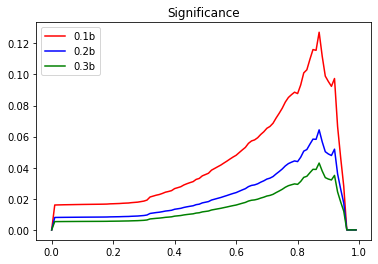

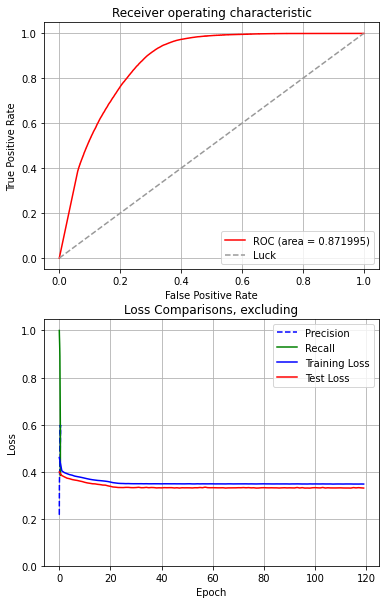

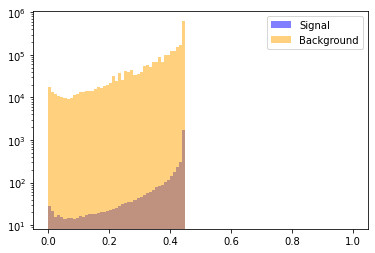

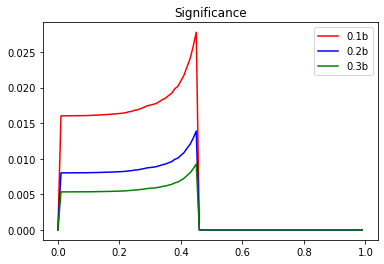

In [38]:
dropnames = ['MET',"METPhi","j1PT","j2Eta","j3Eta","j1Phi","j2Phi","j3Phi","j2PT","j3PT"]
SignificanceArray = []
DropsetArray = []
ScoreArray = []
SscoreArray = []
BscoreArray = []
Storarray = []
AUCArray = []
BWeightsArray = []
SWeightsArray = []
for dropset in powerset(dropnames):
    if len(dropset) == 1:
        #and "j1PT" in dropset and "METPhi" in dropset:
        Storarray.append(dropset)
for item in Storarray:
    if len(item) == 1:
        Signif,Scor,Sscore,Bscore,AUC,Sweights,Bweights = Runall(item)
        SignificanceArray.append(Signif)
        DropsetArray.append(item)
        ScoreArray.append(Scor)
        SscoreArray.append(Sscore)
        BscoreArray.append(Bscore)
        AUCArray.append(AUC)
        BWeightsArray.append(Bweights)
        SWeightsArray.append(Sweights)
SigDF = pd.DataFrame({'Significance':SignificanceArray,'Dropped Variables':DropsetArray,'Score':ScoreArray,'Sscore':SscoreArray,'Bscore':BscoreArray,'AUCArray':AUCArray,'Sweights':SWeightsArray,'Bweights':BWeightsArray})

In [35]:
def statscheck(Sscore,significance,i):
    print(Sscore[i])
    if Sscore[i] > (0.01*(i+1)):
        S += 1
    return(S)

In [36]:
def getmaxima(significance,dropvars,Sscore,AUC,Sweights,Bweights):
    Sscore = np.array(Sscore)
    A = []
    print('Local Maxima for NN, dropping '+str(dropvars))
    for i in range(len(significance)-2):
        if significance[i+1][0] > significance[i+2][0] and significance[i+1][0] > significance[i][0]:
            if len(Bscore[(Bscore > (1-0.01*(i+1)))]) > 10:
                if sum(Sweights[(Sscore > (1-0.01*(i+1)))]) > 3:
                    print(Sscore[(Sscore > (1-0.01*(i+1)))])
                    print(len(Sscore[(Sscore > (1-0.01*(i+1)))]))
                    A.append(str('%.2f'%(significance[i+1][2])))
                    print("local maxima of height "+str('%.2f'%(significance[i+1][0]))+" at score "+str('%.2f'%((1-0.01*(i+1)))))
    return(A)

In [37]:
Barray = []
Carray = []
AUCArray = []
for i in range(len(SigDF)):
    B = getmaxima(SigDF['Significance'][i],SigDF['Dropped Variables'][i],SigDF['Sscore'][i],SigDF['AUCArray'][i],SigDF['Sweights'][i],SigDF['Bweights'][i])
    Barray.append(max(B))
    Carray.append(SigDF['Dropped Variables'][i])
    #,SigDF['Bscore']
print(Barray)

Local Maxima for NN, dropping ()


IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

In [ ]:
cuts = np.arange(0,1,0.01)
for i in range(len(SigDF)):
    b1=[]
    b2=[]
    b3=[]
    for item in SigDF["Significance"][i]:
        b1.append(item[0])
        b2.append(item[1])
        b3.append(item[2])
    plt.plot(cuts,b1)
    plt.plot(cuts,b2)
    plt.plot(cuts,b3)
    plt.ylim(0,3)
    plt.title("Significance Dropping "+str(SigDF["Dropped Variables"][i]))
    plt.show()

## Histogramming Proof

In [ ]:
"""
#Signal Data

s_MET = list_signal['MET']
s_mjj = list_signal['mjj']
s_j1PT = list_signal['j1PT']
s_j1Eta = list_signal['j1Eta']
s_j1Phi = list_signal['j1Phi']
s_j2PT = list_signal['j2PT']
s_j2Eta = list_signal['j2Eta']
s_j2Phi = list_signal['j2Phi']
s_METPhi = list_signal['METPhi']
s_weight = list_signal['weight']
s_j3PT = list_signal['j3PT']
s_j3Eta = list_signal['j3Eta']
s_j3Phi = list_signal['j3Phi']

#Summed Background Data

b_MET = shuffleBackground['MET']
b_mjj = shuffleBackground['mjj']
b_j1PT = shuffleBackground['j1PT']
b_j1Eta = shuffleBackground['j1Eta']
b_j1Phi = shuffleBackground['j1Phi']
b_j2PT = shuffleBackground['j2PT']
b_j2Eta = shuffleBackground['j2Eta']
b_j2Phi = shuffleBackground['j2Phi']
b_METPhi = shuffleBackground['METPhi']
b_weight = shuffleBackground['weight']
b_j3PT = shuffleBackground['j3PT']
b_j3Eta = shuffleBackground['j3Eta']
b_j3Phi = shuffleBackground['j3Phi']

#EWK Background Data

e_MET = list_ewk['MET']
e_mjj = list_ewk['mjj']
e_j1PT = list_ewk['j1PT']
e_j1Eta = list_ewk['j1Eta']
e_j1Phi = list_ewk['j1Phi']
e_j2PT = list_ewk['j2PT']
e_j2Eta = list_ewk['j2Eta']
e_j2Phi = list_ewk['j2Phi']
e_METPhi = list_ewk['METPhi']
e_weight = list_ewk['weight']
e_j3PT = list_ewk['j3PT']
e_j3Eta = list_ewk['j3Eta']
e_j3Phi = list_ewk['j3Phi']

#QCD Background Data

q_MET = list_qcd['MET']
q_mjj = list_qcd['mjj']
q_j1PT = list_qcd['j1PT']
q_j1Eta = list_qcd['j1Eta']
q_j1Phi = list_qcd['j1Phi']
q_j2PT = list_qcd['j2PT']
q_j2Eta = list_qcd['j2Eta']
q_j2Phi = list_qcd['j2Phi']
q_METPhi = list_qcd['METPhi']
q_weight = list_qcd['weight']
q_j3PT = list_qcd['j3PT']
q_j3Eta = list_qcd['j3Eta']
q_j3Phi = list_qcd['j3Phi']
"""

In [ ]:
"""
plt.subplot(211)
plt.title('MET & Combined Backgrounds')
plt.hist(s_MET, bins=100, weights=s_weight, range=(200,3000), alpha=0.5, color='orange', label='Signal MET')
plt.hist(b_MET, bins=100, weights=b_weight, range=(200,3000), alpha=0.5, color='purple', label='Background MET')
plt.yscale('log')
plt.legend()
plt.show()

plt.subplot(212)
plt.title('MET & Seperate Backgrounds')
plt.hist(e_MET, bins=100, weights=e_weight, range=(200,3000), alpha=0.5, color='red', label='EWK MET')
plt.hist(q_MET, bins=100, weights=q_weight, range=(200,3000), alpha=0.5, color='blue', label='QCD MET')
plt.hist(s_MET, bins=100, weights=s_weight, range=(200,3000), alpha=0.5, color='orange', label='Signal MET')
plt.yscale('log')
plt.legend()
plt.show()

plt.subplot(211)
plt.title('mjj & Combined Backgrounds')
plt.hist(s_mjj, bins=100, weights=s_weight, range=(200,12000), alpha=0.5, color='orange', label='Signal mjj')
plt.hist(b_mjj, bins=100, weights=b_weight, range=(200,12000), alpha=0.5, color='purple', label='Background mjj')
plt.yscale('log')
plt.legend()
plt.show()

plt.subplot(212)
plt.title('mjj & Seperate Backgrounds')
plt.hist(e_mjj, bins=100, weights=e_weight, range=(200,12000), alpha=0.5, color='red', label='EWK mjj')
plt.hist(q_mjj, bins=100, weights=q_weight, range=(200,12000), alpha=0.5, color='blue', label='QCD mjj')
plt.hist(s_mjj, bins=100, weights=s_weight, range=(200,12000), alpha=0.5, color='orange', label='Signal mjj')
plt.yscale('log')
plt.legend()
plt.show()

plt.subplot(211)
plt.title('j1PT & Combined Backgrounds')
plt.hist(s_j1PT, bins=100, weights=s_weight, range=(200,2000), alpha=0.5, color='orange', label='Signal j1PT')
plt.hist(b_j1PT, bins=100, weights=b_weight, range=(200,2000), alpha=0.5, color='purple', label='Background j1PT')
plt.yscale('log')
plt.legend()
plt.show()

plt.subplot(212)
plt.title('j1PT & Seperate Backgrounds')
plt.hist(e_j1PT, bins=100, weights=e_weight, range=(200,2000), alpha=0.5, color='red', label='EWK j1PT')
plt.hist(q_j1PT, bins=100, weights=q_weight, range=(200,2000), alpha=0.5, color='blue', label='QCD j1PT')
plt.hist(s_j1PT, bins=100, weights=s_weight, range=(200,2000), alpha=0.5, color='orange', label='Signal j1PT')
plt.yscale('log')
plt.legend()
plt.show()

plt.subplot(211)
plt.title('j1Eta & Combined Backgrounds')
plt.hist(s_j1Eta, bins=100, weights=s_weight, range=(-5,5), alpha=0.5, color='orange', label='Signal j1Eta')
plt.hist(b_j1Eta, bins=100, weights=b_weight, range=(-5,5), alpha=0.5, color='purple', label='Background j1Eta')
plt.yscale('log')
plt.legend()
plt.show()

plt.subplot(212)
plt.title('j1Eta & Seperate Backgrounds')
plt.hist(e_j1Eta, bins=100, weights=e_weight, range=(-5,5), alpha=0.5, color='red', label='EWK j1Eta')
plt.hist(q_j1Eta, bins=100, weights=q_weight, range=(-5,5), alpha=0.5, color='blue', label='QCD j1Eta')
plt.hist(s_j1Eta, bins=100, weights=s_weight, range=(-5,5), alpha=0.5, color='orange', label='Signal j1Eta')
plt.yscale('log')
plt.legend()
plt.show()

plt.subplot(211)
plt.title('j1Phi & Combined Backgrounds')
plt.hist(s_j1Phi, bins=100, weights=s_weight, range=(-5,5), alpha=0.5, color='orange', label='Signal j1Phi')
plt.hist(b_j1Phi, bins=100, weights=b_weight, range=(-5,5), alpha=0.5, color='purple', label='Background j1Phi')
plt.yscale('log')
plt.legend()
plt.show()

plt.subplot(212)
plt.title('j1Phi & Seperate Backgrounds')
plt.hist(e_j1Phi, bins=100, weights=e_weight, range=(-5,5), alpha=0.5, color='red', label='EWK j1Phi')
plt.hist(q_j1Phi, bins=100, weights=q_weight, range=(-5,5), alpha=0.5, color='blue', label='QCD j1Phi')
plt.hist(s_j1Phi, bins=100, weights=s_weight, range=(-5,5), alpha=0.5, color='orange', label='Signal j1Phi')
plt.yscale('log')
plt.legend()
plt.show()

plt.subplot(211)
plt.title('j2PT & Combined Backgrounds')
plt.hist(s_j2PT, bins=100, weights=s_weight, range=(200,2000), alpha=0.5, color='orange', label='Signal j2PT')
plt.hist(b_j2PT, bins=100, weights=b_weight, range=(200,2000), alpha=0.5, color='purple', label='Background j2PT')
plt.yscale('log')
plt.legend()
plt.show()

plt.subplot(212)
plt.title('j2PT & Seperate Backgrounds')
plt.hist(e_j2PT, bins=100, weights=e_weight, range=(200,2000), alpha=0.5, color='red', label='EWK j2PT')
plt.hist(q_j2PT, bins=100, weights=q_weight, range=(200,2000), alpha=0.5, color='blue', label='QCD j2PT')
plt.hist(s_j2PT, bins=100, weights=s_weight, range=(200,2000), alpha=0.5, color='orange', label='Signal j2PT')
plt.yscale('log')
plt.legend()
plt.show()

plt.subplot(211)
plt.title('j2Eta & Combined Backgrounds')
plt.hist(s_j2Eta, bins=100, weights=s_weight, range=(-5,5), alpha=0.5, color='orange', label='Signal j2Eta')
plt.hist(b_j2Eta, bins=100, weights=b_weight, range=(-5,5), alpha=0.5, color='purple', label='Background j2Eta')
plt.yscale('log')
plt.legend()
plt.show()

plt.subplot(212)
plt.title('j2Eta & Seperate Backgrounds')
plt.hist(e_j2Eta, bins=100, weights=e_weight, range=(-5,5), alpha=0.5, color='red', label='EWK j2Eta')
plt.hist(q_j2Eta, bins=100, weights=q_weight, range=(-5,5), alpha=0.5, color='blue', label='QCD j2Eta')
plt.hist(s_j2Eta, bins=100, weights=s_weight, range=(-5,5), alpha=0.5, color='orange', label='Signal j2Eta')
plt.yscale('log')
plt.legend()
plt.show()

plt.subplot(211)
plt.title('j2Phi & Combined Backgrounds')
plt.hist(s_j2Phi, bins=100, weights=s_weight, range=(-5,5), alpha=0.5, color='orange', label='Signal j2Phi')
plt.hist(b_j2Phi, bins=100, weights=b_weight, range=(-5,5), alpha=0.5, color='purple', label='Background j2Phi')
plt.yscale('log')
plt.legend()
plt.show()

plt.subplot(212)
plt.title('j2Phi & Seperate Backgrounds')
plt.hist(e_j2Phi, bins=100, weights=e_weight, range=(-5,5), alpha=0.5, color='red', label='EWK j2Phi')
plt.hist(q_j2Phi, bins=100, weights=q_weight, range=(-5,5), alpha=0.5, color='blue', label='QCD j2Phi')
plt.hist(s_j2Phi, bins=100, weights=s_weight, range=(-5,5), alpha=0.5, color='orange', label='Signal j2Phi')
plt.yscale('log')
plt.legend()
plt.show()

plt.subplot(211)
plt.title('j3PT & Combined Backgrounds')
plt.hist(s_j3PT, bins=100, weights=s_weight, range=(200,3000), alpha=0.5, color='orange', label='Signal j3PT')
plt.hist(b_j3PT, bins=100, weights=b_weight, alpha=0.5, color='purple', label='Background j3PT')
plt.yscale('log')
plt.legend()
plt.show()

plt.subplot(212)
plt.title('j3PT & Seperate Backgrounds')
plt.hist(e_j3PT, bins=100, weights=e_weight, range=(200,2000), alpha=0.5, color='red', label='EWK j3PT')
plt.hist(q_j3PT, bins=100, weights=q_weight, range=(200,2000), alpha=0.5, color='blue', label='QCD j3PT')
plt.hist(s_j3PT, bins=100, weights=s_weight, range=(200,2000), alpha=0.5, color='orange', label='Signal j3PT')
plt.yscale('log')
plt.legend()
plt.show()

plt.subplot(211)
plt.title('j3Eta & Combined Backgrounds')
plt.hist(s_j3Eta, bins=100, weights=s_weight, range=(-5,5), alpha=0.5, color='orange', label='Signal j3Eta')
plt.hist(b_j3Eta, bins=100, weights=b_weight, range=(-5,5), alpha=0.5, color='purple', label='Background j3Eta')
plt.yscale('log')
plt.legend()
plt.show()

plt.subplot(212)
plt.title('j3Eta & Seperate Backgrounds')
plt.hist(e_j3Eta, bins=100, weights=e_weight, range=(-5,5), alpha=0.5, color='red', label='EWK j3Eta')
plt.hist(q_j3Eta, bins=100, weights=q_weight, range=(-5,5), alpha=0.5, color='blue', label='QCD j3Eta')
plt.hist(s_j3Eta, bins=100, weights=s_weight, range=(-5,5), alpha=0.5, color='orange', label='Signal j3Eta')
plt.yscale('log')
plt.legend()
plt.show()

plt.subplot(211)
plt.title('j3Phi & Combined Backgrounds')
plt.hist(s_j3Phi, bins=100, weights=s_weight, range=(-5,5), alpha=0.5, color='orange', label='Signal j3Phi')
plt.hist(b_j3Phi, bins=100, weights=b_weight, range=(-5,5), alpha=0.5, color='purple', label='Background j3Phi')
plt.yscale('log')
plt.legend()
plt.show()

plt.subplot(212)
plt.title('j3Phi & Seperate Backgrounds')
plt.hist(e_j3Phi, bins=100, weights=e_weight, range=(-5,5), alpha=0.5, color='red', label='EWK j3Phi')
plt.hist(q_j3Phi, bins=100, weights=q_weight, range=(-5,5), alpha=0.5, color='blue', label='QCD j3Phi')
plt.hist(s_j3Phi, bins=100, weights=s_weight, range=(-5,5), alpha=0.5, color='orange', label='Signal j3Phi')
plt.yscale('log')
plt.legend()
plt.show()

plt.subplot(211)
plt.title('METPhi & Combined Backgrounds')
plt.hist(s_METPhi, bins=100, weights=s_weight, alpha=0.5, color='orange', label='Signal METPhi')
plt.hist(b_METPhi, bins=100, weights=b_weight, alpha=0.5, color='purple', label='Background METPhi')
plt.yscale('log')
plt.legend()
plt.show()

plt.subplot(212)
plt.title('METPhi & Seperate Backgrounds')
plt.hist(e_METPhi, bins=100, weights=e_weight, alpha=0.5, color='red', label='EWK METPhi')
plt.hist(q_METPhi, bins=100, weights=q_weight, alpha=0.5, color='blue', label='QCD METPhi')
plt.hist(s_METPhi, bins=100, weights=s_weight, alpha=0.5, color='orange', label='Signal METPhi')
plt.yscale('log')
plt.legend()
plt.show()
"""

In [ ]:
'''
main_line= '/home/jupyter-blonsbro/'
sig_line = 'Combined Signal Ntuples.root'
ewk_line = 'Combined EWKBackground Ntuples.root'
qcd_line = 'Combined QCDBackground Ntuples.root'

sig_dir = main_line+sig_line
ewk_dir = main_line+ewk_line
qcd_dir = main_line+qcd_line

main_sig = uproot.open(sig_dir)['Signal;1']
main_ewk = uproot.open(ewk_dir)['EWKBackground;1']
main_qcd = uproot.open(qcd_dir)['QCDBackground;1']

Signal = Event_Organization(main_sig)
EWK = Event_Organization(main_ewk)
QCD = Event_Organization(main_qcd)

Signal_df = pd.DataFrame(Signal)
EWK_df = pd.DataFrame(EWK)
QCD_df = pd.DataFrame(QCD)
'''

In [ ]:
"""
def Event_Organization(Input_Trees):
    tree_branches = Input_Trees.arrays()
    MET = []
    METPhi = []
    j1PT = []
    j1Eta = []
    j1Phi = []
    j2PT = []
    j2Eta = []
    j2Phi = []
    j3PT = []
    j3Eta = []
    j3Phi = []
    weight = []
    mjj = []
    for element in tree_branches['MET']:
        MET.append(element)
    for element in tree_branches['METPhi']:
        METPhi.append(element)
    for element in tree_branches['j1PT']:
        j1PT.append(element)
    for element in tree_branches['j1Eta']:
        j1Eta.append(element)
    for element in tree_branches['j1Phi']:
        j1Phi.append(element)
    for element in tree_branches['j2PT']:
        j2PT.append(element)
    for element in tree_branches['j2Eta']:
        j2Eta.append(element)
    for element in tree_branches['j2Phi']:
        j2Phi.append(element)
    for element in tree_branches['j3PT']:
        j3PT.append(element)
    for element in tree_branches['j3Eta']:
        j3Eta.append(element)
    for element in tree_branches['j3Phi']:
        j3Phi.append(element)
    for element in tree_branches['weight']:
        weight.append(element)
    for element in tree_branches['mjjoptimized']:
        mjj.append(element)
            
    Output = {'MET':MET, 'METPhi':METPhi, 'j1PT':j1PT, 'j1Eta':j1Eta, 'j1Phi':j1Phi, 'j2PT':j2PT, 'j2Eta':j2Eta, 'j2Phi':j2Phi,
         'j3PT':j3PT, 'j3Eta':j3Eta, 'j3Phi':j3Phi, 'weight':weight, 'mjj':mjj}
        
    return(Output)
    """